In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
import os
import tifffile as tiff
from glob import glob
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from skimage import io
import cv2
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.utils import compute_sample_weight
from optuna.pruners import SuccessiveHalvingPruner
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from optuna.visualization import plot_optimization_history
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torchvision.models as models
import optuna
from pytorch_model_summary import summary
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import auc













if torch.cuda.is_available():
    print("Using GPU...")
    dev = "cuda:0"
else:
    print("Using CPU...")
    dev = "cpu"
    
    
device = torch.device(dev)






#Set the random seed for reproducibility 
torch.manual_seed(2020) 



class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # Transform the 28 by 28 image to an embedded code size of 30
            nn.Linear(38400, 30),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(30, 38400),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        # x will be a (batch_size,1,28,28) tensor when using MNIST
        # so we will reshape it to a (batch_size, 28*28) flat tensor.
        # After it has been decoded we will reshape back to the image shape.
        x = self.encoder(x.view(-1, 38400))
        x = self.decoder(x)
        return x.view(-1, 1, 160, 240)




class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ReLU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0) # conv layer
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x







class ConvAutoencoder2D(nn.Module):
    def __init__(self):
        super(ConvAutoencoder2D, self).__init__()
        self.encoder = nn.Sequential(
            # 1 input image channel, 16 output channel, 3x3 square convolution
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),  # activation function
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # conv layer
            nn.ReLU(), # activation function 
            nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=0), # conv layer
            nn.ReLU(),
            #nn.Linear( 64*1*1, 2)
            nn.Linear( 64*1*1, 2)
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(64, 32, kernel_size=7, stride=1, padding=0), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # conv transpose layer
            nn.ReLU(), # activation function
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  #to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Using GPU...


In [ ]:
imgA = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all/Test017_141.tif'
imgB = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all/Test017_143.tif'


imlist = [imgA,imgB]

w,h=Image.open(imlist[0]).size
N=len(imlist)

arr=np.zeros((h,w),float)


for im in imlist:
    imarr=np.array(Image.open(im),dtype=float)
    arr=arr+imarr/N


arr=np.array(np.round(arr),dtype=np.uint8)

out=Image.fromarray(arr)
#out.save("017_142.tif")
#out.show()


path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all'
imageList = [os.path.join(path, file) for file in os.listdir(path)]
print(imageList[0])

w,h=Image.open(imageList[0]).size
N=len(imageList)

avgArr=np.zeros((h,w),float)

for im in imageList:
    imageArr=np.array(Image.open(im),dtype=float)
    avgArr=avgArr+imageArr/N
    
avgArr=np.array(np.round(avgArr),dtype=np.uint8)
    
avg=Image.fromarray(avgArr)
#avg.save("Test_avg.tif")
avg.show()

    


In [2]:


num_epochs = 30

"""
class AnomalyDataset(data.Dataset):
    
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.folder_names = os.listdir(self.img_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.folder_names)
        
    
    def __getitem__(self, index):
        #img_path = self.img_dir[index]
        #image = Image.open(img_path)
        #avg = Image.open('Test_avg.tif')
        #image1 = np.asarray(image)
        #image2 = np.asarray(avg)
        #image = image1 - image2
        #image = Image.fromarray(image)
        #image.show()
        #if self.transform:
        #    image = self.transform(image)
        
        folder_path = os.path.join(self.img_dir, self.folder_names[index])
        image_filenames = os.listdir(folder_path)
        
        images = []
        for img in image_filenames:
            if img.endswith('.tif'):
                image_path = os.path.join(folder_path, img)
                image = Image.open(image_path)
            
                if self.transform:
                    image = self.transform(image)
                images.append(image)
            
        return images
      
      
"""   

        
path = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/All_data'
data_transforms = transforms.Compose([transforms.Resize((160, 240)), transforms.ToTensor()])

#dataset = AnomalyDataset(path, data_transforms)



#dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    
    

root_dir = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/All_data'
num_folders = 70
num_images_per_folder = 200
image_height = 160
image_width = 240

dataset = np.zeros((num_folders, num_images_per_folder, image_height, image_width))

for i in range(num_folders):
    folder_name = str(i+1).zfill(3)
    folder_path = os.path.join(root_dir, folder_name)

    for j in range(num_images_per_folder):
        image_name = str(j+1).zfill(3) + '.tif'
        image_path = os.path.join(folder_path, image_name)

        image = Image.open(image_path)
        image = image.resize((image_width, image_height))
        
        image = np.array(image)
        dataset[i, j, :, :] = image
    
    
    
print(dataset.shape)
dataset_norm = dataset/255.0

np.save('UCSD_Ped1', dataset_norm)

#dataset_tensor = torch.tensor(dataset)
#print(dataset_tensor.shape)



                
                
            
            
            
            

#image_path_train = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train_all'
#image_paths_train = glob(image_path_train + '/*.tif')
#data_transforms = transforms.Compose([transforms.Resize((160, 240)), transforms.ToTensor()])



#image_path_test = './UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test_all'
#image_paths_test = glob(image_path_test + '/*.tif')

#dataset_train = AnomalyDataset(image_paths_train, data_transforms)
#dataset_train2 = AnomalyDataset(image_paths_test, data_transforms)




#dataset = UCSDAnomalyDataset('./UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train', time_stride=1)
#data_train = data.DataLoader(dataset, batch_size=32, shuffle=True)



(70, 200, 160, 240)


In [3]:
label_start = 34
labels = np.zeros((num_folders, num_images_per_folder, 1))
"""    
labels = np.zeros(7200, dtype=np.int8)
import csv
with open('labels.txt', 'r') as file:
    for i, line in enumerate(file):
        if("," in line):
            #part1 = line.rstrip().split(',')[0]
            #part2 = line.rstrip().split(',')[1]
            start1 = int(line.rstrip().split(',')[0].split(':')[0])-1+(i*200)
            end1 = int(line.rstrip().split(',')[0].split(':')[1])+1+(i*200)
            
            labels[start1:end1] = 1
            
            start2 = int(line.rstrip().split(',')[1].split(':')[0])-1+(i*200)
            end2 = int(line.rstrip().split(',')[1].split(':')[1].replace(';', ''))+1+(i*200)
            
            labels[start2:end2] = 1
            
            
        else:
            start3 = int(line.rstrip().split(';')[0].split(':')[0])-1+(i*200)
            end3 = int(line.rstrip().split(';')[0].split(':')[1])+1+(i*200)
            #s = slice(*map(int, frames.split(':')))
            #print(s)
            labels[start3:end3] = 1
            
"""
            
            
            
with open("labels.txt", "r") as f:
    for i, line in enumerate(f):
        parts = line.strip().split(";")
        if ("," in line):
            indices = parts[0].strip().split(",")
            for index in indices:
                start, end = index.strip().split(":")
                start = int(start) - 1
                end = int(end) - 1
                
                labels[i+label_start, start:end, 0] = 1
        else:
            start, end = parts[0].strip().split(":")
            start = int(start) - 1
            end = int(end) - 1
            
            labels[i+label_start, start:end, 0] = 1
                
                
                
print(labels.shape)
print(np.sum(labels.flatten() == 1))

(70, 200, 1)
4005


In [4]:

X_train, X_test, y_train, y_test = train_test_split(dataset_norm, labels, test_size=0.2, random_state=42)
print(y_test.shape)


#img = Image.fromarray(np.uint8(X_train[0][0]))

#plt.imshow(img)
#plt.show()





#cae.to(device)
    




def do_pca(n_components, train_data, val_data, test_data):
    pca = PCA(n_components)
    
    #train_data = train_data.numpy()
    num_videos, num_frames, height, width = train_data.shape
    data_train = train_data.reshape(num_videos*num_frames, height*width)
    print(data_train.shape)
    
    transformed_train_images = pca.fit_transform(data_train)
    reconstructed_train_images = pca.inverse_transform(transformed_train_images)
    print(reconstructed_train_images.shape)
    
    #test_data = test_data.numpy()
    num_videos, num_frames, height, width = test_data.shape   
    data_test = test_data.reshape(num_videos*num_frames, height*width)
    transformed_test_images = pca.transform(data_test)
    reconstructed_test_images = pca.inverse_transform(transformed_test_images)
    
    
    num_videos, num_frames, height, width = val_data.shape   
    data_val = val_data.reshape(num_videos*num_frames, height*width)
    transformed_val_images = pca.transform(data_val)
    reconstructed_val_images = pca.inverse_transform(transformed_val_images)
    

    print(np.cumsum(pca.explained_variance_ratio_))

    plt.plot(np.arange(1,n_components+1), pca.explained_variance_ratio_)
    # Plotting using a log scale might show more information
    plt.yscale('log')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.show()

    plt.plot(np.arange(1,n_components+1), np.cumsum(pca.explained_variance_ratio_))
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.xlabel('Number of Components')
    plt.show()
    



    reconstruction_error_train = mean_squared_error(data_train, reconstructed_train_images)
    print('Train Reconstruction error is ', reconstruction_error_train)
    print("\n\n")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data_train[1].reshape(160, 240), cmap='Greys_r')

    # Plot the second image
    plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(reconstructed_train_images[1].reshape(160, 240), cmap='Greys_r')

    plt.show()
    
    reconstruction_error_val = mean_squared_error(data_val, reconstructed_val_images)
    print('Val Reconstruction error is ', reconstruction_error_val)
    print("\n\n")

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(data_val[1].reshape(160, 240), cmap='Greys_r')

    # Plot the second image
    plt.subplot(1, 2, 2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(reconstructed_val_images[1].reshape(160, 240), cmap='Greys_r')
    
    return transformed_train_images, transformed_val_images, transformed_test_images

    
    
print("==========PCA TRAIN/TEST==========")
#pca_100_train, pca_100_test = do_pca(100, X_train, X_test)
#pca_200_train, pca_200_test = do_pca(200, X_train, X_test)
#pca_400_train, pca_400_test = do_pca(400, X_train, X_test)
#pca_600_train, pca_600_test = do_pca(600, X_train, X_test)





(14, 200, 1)
==========PCA TRAIN/TEST==========


In [ ]:
ae = Autoencoder()
cae = ConvAutoencoder()
cae2D = ConvAutoencoder2D()

#print(ae)
#print("==============Standard Autoencoder===========")
#outputs = train_AE(ae, dataset, max_epochs=30, print_steps=30)
#print("\n\n")

"""
numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].numpy()    
    recon = outputs[k][2].numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
"""


print("==============ConvAutoencoder TRAIN==============")
outputs = train_AE(cae, X_train, max_epochs=30, print_steps=30)
print("\n\n")



        
        
print("\n\n")
print("==============ConvAutoencoder TEST==============")
outputs = train_AE(cae, X_test, max_epochs=30, print_steps=30)
print("\n\n")



        
numOut = len(outputs)-1
numImgs=12;
for k in range(0, len(outputs), 9):
    plt.figure(figsize=(numImgs, 2))
    imgs = outputs[k][1].cpu().numpy()    
    recon = outputs[k][2].cpu().numpy()
    print('Epoch:', k+1)
    for i, item in enumerate(imgs):
        if i >= numImgs: break
        plt.subplot(2, numImgs, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= numImgs: break
        plt.subplot(2, numImgs, numImgs+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(item[0])
        

plt.figure(figsize=(16, 4))
imgs = outputs[numOut][1].cpu().numpy()    
recon = outputs[numOut][2].cpu().numpy()

for i in range(8):
    # Top row: show original faces
    plt.subplot(2,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[i][0].reshape(160,240), cmap='Greys_r')
    # Bottom row: show reconstructions
    plt.subplot(2,8, 8+i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recon[i][0].reshape(160,240), cmap='Greys_r')
plt.show()
        

In [ ]:
def train_AE(model, dataset, max_epochs=20, print_steps=5):
    #Training (optimisation) parameters
    batch_size=64
    learning_rate=1e-3

    #Choose mean square error loss
    criterion = nn.MSELoss() 

    #Choose the Adam optimiser
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    #Specify how the data will be loaded in batches (with random shuffling)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    #Storage
    outputs = []
    
    model.to(device)
    #train_loader = train_loader.cuda()

    #Start training
    for epoch in range(max_epochs):
        for img in train_loader:
            img = img.to(device)
            recon = model(img.float())
            #print(recon.shape)
            loss = criterion(recon, img.to(device))

            loss.backward()
            optimizer.step()  
            optimizer.zero_grad()
          
        #if ((epoch % print_steps) == 0) or (epoch +1 == max_epochs):
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, loss.item()))
        outputs.append((epoch, img.detach(), recon.detach()),)

    return outputs

In [ ]:
#print(outputs[29][1].cpu().numpy().shape)
#print(outputs[29][])
#print(pca_400.shape)

#linearModel = LinearRegression()

#linearOutputs = trainLinearModel(linearModel, pca_400, labels, 50, 50)

V, F = y_train.shape[:2]
labels_train = np.reshape(y_train, (V*F, 1))

V, F = y_test.shape[:2]
labels_test = np.reshape(y_test, (V*F, 1))
labels_test_log = labels_test.ravel()
labels_train_log = labels_train.ravel()

linearPCA = RidgeClassifier().fit(pca_400_train, labels_train_log)

y_pred = linearPCA.predict(pca_400_test)
accuracy = balanced_accuracy_score(labels_test_log, y_pred)
print("Accuracy of Ridge Classifier: ", accuracy)
auc = roc_auc_score(labels_test_log, y_pred)
print("AUC score for Ridge Classifier: ", auc)
print("F1 score for Ridge Classfier", f1_score(labels_test_log, y_pred))

#linearPCA.score(pca_400_test, labels_test)


clf = LogisticRegression().fit(pca_400_train, labels_train_log)
pred = clf.predict(pca_400_test)
acc = balanced_accuracy_score(labels_test_log, pred)

print("Accuracy of Logistic regression: ", acc)
auc_log = roc_auc_score(labels_test_log, pred)
print("AUC score for Logistic regression: ", auc_log)
print("F1 score for Logistic regression", f1_score(labels_test_log, pred))



    


#linearAE = RidgeClassifier().fit(outputs[29][1].cpu().numpy().flatten().reshape(-1, 1), labels)
#linearAE.score(outputs[29][1].cpu().numpy(), labels)

In [5]:

class ESN(BaseEstimator):
    def __init__(self, input_size, reservoir_size, output_size, leaking_rate=0.95, spectral_radius=1, input_scaling=1, threshold=0.5, sparsity=0.1, ridge_alpha=0.5, random_seed=83):
        np.random.seed(random_seed)
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = output_size

        self.W_in = np.random.randn(reservoir_size, input_size)
        self.W_res = np.random.randn(reservoir_size, reservoir_size)
        
        self.leaking_rate = leaking_rate
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.threshold = threshold
        self.sparsity = sparsity
        self.ridge_alpha = ridge_alpha
        
        e, v = np.linalg.eig(self.W_res)
        max_abs = np.max(np.abs(e))
        self.W_res = self.W_res/max_abs
        M = (np.random.uniform(size=(reservoir_size, reservoir_size)) < self.sparsity) * 1.0
        self.W_res *= M
        
        self.h0 = np.zeros((reservoir_size, 1))


        

        
        
        
        
    def update(self, x):
        h = self.h0
        T = x.shape[0]
        states = np.zeros((T, self.reservoir_size))

        for t in range(T):
            h = self.leaking_rate * np.tanh(self.spectral_radius * self.W_res @ h + self.input_scaling * self.W_in @ 
                                                                                 x[t].reshape(-1, 1)) + (1-self.leaking_rate)*h
            
            states[t] = h.flatten()
                    
        return states
    

    def fit(self, X, y):
        V, F, D = X.shape
        self.W_out = np.random.randn(self.output_size, self.reservoir_size)
        states = np.zeros((V, F, self.reservoir_size))
        
        for v in range(V):
            states[v] = self.update(X[v])
        
        states = states.reshape(V*F, self.reservoir_size)
        
            
        
        ridge = Ridge(alpha=self.ridge_alpha)
        weights = compute_sample_weight(class_weight='balanced', y=y.flatten())
        ridge.fit(states, y.flatten(), sample_weight=weights)
        self.W_out = ridge.coef_
            
        return self.W_out

        
        
            
    
    
    def predict(self, X):
        V, F, D = X.shape
        pred = np.zeros((V, F, 1))
        outputs = np.zeros((V, F, 1))
        
        for v in range(V):
            states = self.update(X[v])
            
            
            for f in range(F):
                state = states[f]
                output = np.dot(state.reshape(-1, 1).T, self.W_out.reshape(self.reservoir_size, -1))
                pred[v][f] = (output >= self.threshold).astype(int)
                outputs[v][f] =  output
        
        return pred, outputs
            
            
            #print(states.shape)
            #y = states @ self.W_out[v].T
            #print(y.shape)
            #print(self.W_out.shape)
            #print("W_out", self.W_out[v].shape)
            #print("states", states.shape)
            
            #w = self.W_out[v].reshape(self.reservoir_size, 1)
            #y_pred[v] = sigmoid(np.sum(w * states.reshape((1, F, self.reservoir_size, 1)), axis=2))

            #print("New W: ", w.shape)
            #w = self.W_out[v].reshape((1, F, self.reservoir_size, 1))
            #s = states.reshape((1, F, self.reservoir_size, 1))
            #print("w", w.shape)
            #print("s", s.shape)
            
            #y_prob = np.zeros((F, 1))
            #y_pred = np.dot(self.W_out, states.T)
            #y_prob = softmax(y_pred)
            #y_pred_labels = np.argmax(y_prob, axis=1)
            #for t in range(F):
            #    y_pred = np.dot(self.W_out, states[t])
            #    y_prob[t] = sigmoid(y_pred)
                
            #y_prob = sigmoid(y_pred)
            #print(y_prob.T.shape)
            #probs[v] = y_prob.reshape(-1, 1)
            #print(y_pred[2])
            #print("y_pred", y_pred.reshape(-1, 1).shape)
            
            #y_pred = softmax(self.W_out[v] @ states.T)
            #print(y_pred.shape)
            #pred[v] = (y_prob.reshape(-1, 1) >= self.threshold).astype(int)
            
            
        #return pred, probs
        
        
        
        
        
        

        
        

    





In [ ]:
VF, D = pca_200_train.shape
V = int(VF/200)
F = 200
train_data = pca_200_train.reshape(V, F, D)

print(train_data.shape)

#train_states = None

    
VF, D = pca_200_test.shape
V = int(VF/200)
F = 200
test_data = pca_200_test.reshape(V, F, D)
print(test_data.shape)


X_train_new, X_val, y_train_new, y_val = train_test_split(train_data, y_train, test_size=0.25, random_state=42)

In [6]:
X_train_hyp, X_val_hyp, y_train_hyp, y_val_hyp = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:

print(np.sum(y_train_hyp==1))


Nf = 200
H = 160
W = 240
Nv_train = len(X_train_hyp)

x_train_hyp = X_train_hyp.reshape(Nv_train*Nf, H*W)
y_train_hyp = y_train_hyp.reshape(Nv_train*Nf, 1)

oversampler = RandomOverSampler()
x_train_oversampled, y_train_oversampled = oversampler.fit_resample(x_train_hyp, y_train_hyp)



# Recalculate class weights after oversampling
#class_weights_oversampled = compute_class_weight('balanced', np.unique(y_train_oversampled), y_train_oversampled)

plt.imshow(x_train_oversampled[140].reshape(H, W), cmap='gray')
plt.axis('off')  # Optional: to hide the axes
plt.show()




In [ ]:

#batch_size = 50

print(x_train_oversampled.shape)
x_train_oversampled = x_train_oversampled[:-116]
y_train_oversampled = y_train_oversampled[:-116]

print(np.sum(y_train_oversampled==1))
Nv_train = int(len(x_train_oversampled) / Nf)
Nv_val = len(X_val_hyp)
Nv_test = len(X_test)

x_train_oversampled = x_train_oversampled.reshape(Nv_train, Nf, H, W)
y_train_oversampled = y_train_oversampled.reshape(Nv_train, Nf, 1)




x_train_mean = x_train_oversampled.mean(axis=0)
x_train_std = x_train_oversampled.std(axis=0)
x_train_nomean = (x_train_oversampled - x_train_mean) / x_train_std
x_val_nomean = (X_val_hyp - x_train_mean) / x_train_std
x_test_nomean = (X_test - x_train_mean) / x_train_std

plt.imshow(x_train_nomean[0][140], cmap='gray')
plt.axis('off')  # Optional: to hide the axes
plt.show()









x_train_nomean = x_train_nomean.reshape(Nv_train*Nf, 1, H, W)
y_train_oversampled = y_train_oversampled.reshape(Nv_train*Nf, 1)


x_val_nomean = x_val_nomean.reshape(Nv_val*Nf, 1, H, W)
y_val_hyp = y_val_hyp.reshape(Nv_val*Nf, 1)

print(x_train_nomean.shape)
print(y_train_oversampled.shape)

train_Ntrue = y_train_oversampled.sum()
train_c1_w = 1.0/train_Ntrue
train_c0_w = 1.0/(len(y_train_oversampled) - train_Ntrue)
train_c_wtot = train_c1_w + train_c0_w
train_c1_w /= train_c_wtot
train_c0_w /= train_c_wtot

train_c_w = (1-y_train_oversampled)*train_c0_w + y_train_oversampled*train_c1_w






print(train_Ntrue, train_c0_w, train_c1_w)



x_test_nomean = x_test_nomean.reshape(Nv_test*Nf, 1, H, W)
y_test = y_test.reshape(Nv_test*Nf, 1)

test_Ntrue = y_test.sum()
test_c1_w = 1.0/test_Ntrue
test_c0_w = 1.0/(len(y_test) - test_Ntrue)
test_c_wtot = test_c0_w + test_c1_w
test_c1_w /= test_c_wtot
test_c0_w /= test_c_wtot

test_c_w = (1-y_test)*test_c0_w + y_test*test_c1_w



val_Ntrue = y_val_hyp.sum()
val_c1_w = 1.0/val_Ntrue
val_c0_w = 1.0/(len(y_val_hyp) - val_Ntrue)
val_c_wtot = val_c1_w + val_c0_w
val_c1_w /= val_c_wtot
val_c0_w /= val_c_wtot

val_c_w = (1-y_val_hyp)*val_c0_w + y_val_hyp*val_c1_w








In [ ]:
class CNN(nn.Module):
    def __init__(self, hidden_size_1=1000, hidden_size_2=200):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=11, stride=4, padding=5)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 16, kernel_size=5, stride=4, padding=2)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(16*10*15, hidden_size_1)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        hidden = self.relu3(x)
        x = self.fc2(hidden)
        x = self.relu4(x)
        return hidden, x
    
    
    
    
#torch.cuda.empty_cache()


    
    






hidden_size_1 = 1000
hidden_size_2 = 200




"""
model = nn.Sequential(
    nn.Conv2d(1, 16, 11, padding=5, stride=4),
    nn.ReLU(),
    nn.Conv2d(16, 16, 5, padding=2, stride=4),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(16*10*15, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1),
    nn.Sigmoid()
)
"""


"""model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 40 * 60, 1000),
    nn.ReLU(),
    nn.Linear(1000, 200),
    nn.ReLU(),
    nn.Linear(200,1),
    nn.Sigmoid()
)"""

"""model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 40 * 60, 1000),
    nn.ReLU(),
    nn.Linear(1000, 400),
    nn.ReLU(),
    nn.Linear(400,1),
    nn.Sigmoid()
)"""



"""model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(128 * 20 * 30, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
)"""




def objective(trial):
    model = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(240*160, 2000),
        nn.ReLU(),
        nn.Linear(2000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 200),
        nn.ReLU(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )
    
    model.to(device)
    
    
    
    
    lr = trial.suggest_float('learning_rate', 1e-9, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [25, 50, 100])
    #Nepochs = trial.suggest_int('Nepochs', 25, 60)


    #lr = 1e-6
    #weight_decay = 1e-3

    #loss_criterion = nn.MSELoss() 
    #loss_criterion = nn.CrossEntropyLoss()
    #loss_criterion = nn.BCELoss() 
    #loss_criterion = lambda pred, true, weight: weight*
    
    
    
    
    trainset = TensorDataset(torch.Tensor(x_train_nomean).to(device), torch.Tensor(y_train_oversampled).to(device), torch.Tensor(train_c_w).to(device))
    train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = TensorDataset(torch.Tensor(x_test_nomean).to(device), torch.Tensor(y_test).to(device), torch.Tensor(test_c_w).to(device))
    test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

    valset = TensorDataset(torch.Tensor(x_val_nomean).to(device), torch.Tensor(y_val_hyp).to(device), torch.Tensor(val_c_w).to(device))
    val_dl = DataLoader(valset, batch_size=batch_size, shuffle=False)
    
    loss_criterion = F.binary_cross_entropy
    optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    Nepochs=15

    
    train_losses = []
    val_losses = []
    test_losses = []


    tr_preds = np.zeros((len(train_dl), batch_size, 1))
    tr_trues = np.zeros((len(train_dl), batch_size, 1))

    val_preds = np.zeros((len(val_dl), batch_size, 1))
    val_trues = np.zeros((len(val_dl), batch_size, 1))
    
    te_preds = np.zeros((len(test_dl), batch_size, 1))
    te_trues = np.zeros((len(test_dl), batch_size, 1))
    



    for n in range(Nepochs):
        model.train()
        tr_avg_loss = 0.0
        tr_avg_acc = 0.0

        for i,batch in enumerate(train_dl):
            x, y_true, c_w = batch
            x = x.to(device)
            y_true = y_true.to(device)
            c_w = c_w.to(device)
            optimiser.zero_grad()
            y = model(x)
            loss = loss_criterion(y, y_true, weight=c_w)
            pred_class = (y > 0.5)
            true_class = (y_true > 0.5)
            tr_avg_acc += (pred_class == true_class).sum().item()

            tr_preds[i] = pred_class.detach().cpu().numpy()
            tr_trues[i] = true_class.detach().cpu().numpy()

            tr_avg_loss += loss.item()
            loss.backward()
            optimiser.step()
        tr_avg_loss /= len(train_dl)
        tr_avg_acc /= len(train_dl)*batch_size

        tr_prec = precision_score(tr_trues.flatten(), tr_preds.flatten(), zero_division=0)
        tr_recall = recall_score(tr_trues.flatten(), tr_preds.flatten(), zero_division=0)
        tr_f1 = f1_score(tr_trues.flatten(), tr_preds.flatten(), zero_division=0)
        tr_bal_acc = balanced_accuracy_score(tr_trues.flatten(), tr_preds.flatten())

        model.eval()
        val_avg_loss = 0.0
        val_avg_acc = 0.0
        
        te_avg_loss = 0.0
        te_avg_acc = 0.0


        with torch.no_grad():
            for i, batch in enumerate(val_dl):
                x, y_true, c_w = batch
                y = model(x)
                loss = loss_criterion(y, y_true, weight=c_w)
                val_avg_loss += loss.item()
                pred_class = (y > 0.5)
                true_class = (y_true > 0.5)
                val_avg_acc += (pred_class == true_class).sum().item()
                val_preds[i] = pred_class.detach().cpu().numpy()
                val_trues[i] = true_class.detach().cpu().numpy()
        val_avg_loss /= len(val_dl)
        val_avg_acc /= len(val_dl)*batch_size

        val_prec = precision_score(val_trues.flatten(), val_preds.flatten(), zero_division=0)
        val_recall = recall_score(val_trues.flatten(), val_preds.flatten(), zero_division=0)
        val_f1 = f1_score(val_trues.flatten(), val_preds.flatten(), zero_division=0)
        val_bal_acc = balanced_accuracy_score(val_trues.flatten(), val_preds.flatten())
        
        
        
        with torch.no_grad():
            for i, batch in enumerate(test_dl):
                x, y_true, c_w = batch
                y = model(x)
                loss = loss_criterion(y, y_true, weight=c_w)
                te_avg_loss += loss.item()
                pred_class = (y > 0.5)
                true_class = (y_true > 0.5)
                te_avg_acc += (pred_class == true_class).sum().item()
                te_preds[i] = pred_class.detach().cpu().numpy()
                te_trues[i] = true_class.detach().cpu().numpy()
        te_avg_loss /= len(val_dl)
        te_avg_acc /= len(val_dl)*batch_size

        te_prec = precision_score(te_trues.flatten(), te_preds.flatten(), zero_division=0)
        te_recall = recall_score(te_trues.flatten(), te_preds.flatten(), zero_division=0)
        te_f1 = f1_score(te_trues.flatten(), te_preds.flatten(), zero_division=0)
        te_bal_acc = balanced_accuracy_score(te_trues.flatten(), te_preds.flatten())
        
        
        train_losses.append(tr_avg_loss)
        val_losses.append(val_avg_loss)
        test_losses.append(te_avg_loss)
        
        #print(n, tr_avg_loss, tr_avg_acc, tr_bal_acc, te_avg_loss, te_avg_acc, tr_f1, te_f1)
        #print("Epoch, Loss, Acc, Bal Acc, F1")
        #print(n, tr_avg_loss, tr_avg_acc, tr_bal_acc, tr_f1)
        print("Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Train Bal Acc: {:.4f}, Train F1: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}, Val Bal Acc: {:.4f}, Val F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test bal Acc: {:.4f}, Test F1: {:.4f}".format(n, tr_avg_loss, tr_avg_acc, tr_bal_acc, tr_f1, val_avg_loss, val_avg_acc, val_bal_acc, val_f1, te_avg_loss, te_avg_acc, te_bal_acc, te_f1))
        
        
    plt.plot(range(1, Nepochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, Nepochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
        
    return val_f1



study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust the number of trials as needed

best_params = study.best_params
best_score = study.best_value
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")









In [ ]:

"""model = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(240*160, 1000),
            nn.ReLU(),
            nn.Linear(1000, 200),
            nn.ReLU(),
            nn.Linear(200, 1),
            nn.Sigmoid()
)"""


"""model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32 * 20 * 30, 256),
    nn.ReLU(),
    nn.Linear(256, 1),
    nn.Sigmoid()
)"""


"""model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * 37 * 57, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 1),
            nn.Sigmoid()
        )"""


"""model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.AdaptiveAvgPool2d((6, 6)),
        nn.Flatten(),
        nn.Linear(9216, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096, 1)
    )"""


"""model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(128 * 20 * 30, 256),
        nn.ReLU(),
        nn.Dropout(0.5),  # Adding dropout for regularization
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.5),  # Adding dropout for regularization
        nn.Linear(128, 1),
        nn.Sigmoid()
    )"""



"""model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 40 * 60, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 1),
        nn.Sigmoid()
)"""

model = nn.Sequential(
        nn.Flatten(start_dim=1),
        nn.Linear(240*160, 2000),
        nn.ReLU(),
        nn.Linear(2000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 200),
        nn.ReLU(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )



"""model = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=7, stride=4, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(64 * 10* 15, 1000),
        nn.ReLU(),
        nn.Linear(1000, 200),
        nn.ReLU(),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )"""






batch_size=50

trainset = TensorDataset(torch.Tensor(x_train_nomean).to(device), torch.Tensor(y_train_oversampled).to(device), torch.Tensor(train_c_w).to(device))
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(torch.Tensor(x_test_nomean).to(device), torch.Tensor(y_test).to(device), torch.Tensor(test_c_w).to(device))
test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

valset = TensorDataset(torch.Tensor(x_val_nomean).to(device), torch.Tensor(y_val_hyp).to(device), torch.Tensor(val_c_w).to(device))
val_dl = DataLoader(valset, batch_size=batch_size, shuffle=False)







model.to(device)


input_size = (batch_size, 1, 160, 240)
dummy_input = torch.zeros(*input_size).to(device)
print(summary(model, dummy_input))
    
    
    
    



lr = 8.934318672104453e-08
weight_decay = 0.000944102527466085

#lr = 1.366846905030724e-07
#weight_decay = 0.0007454955263198514


#lr = 1e-6
#weight_decay = 1e-3


#loss_criterion = nn.MSELoss() 
#loss_criterion = nn.BCELoss() 
#loss_criterion = lambda pred, true, weight: weight*
loss_criterion = F.binary_cross_entropy
optimiser = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

Nepochs=5


train_losses = []
val_losses = []
train_f1s = []
val_f1s = []


tr_preds = np.zeros((len(train_dl), batch_size, 1))
tr_trues = np.zeros((len(train_dl), batch_size, 1))

te_preds = np.zeros((len(val_dl), batch_size, 1))
te_trues = np.zeros((len(val_dl), batch_size, 1))

best_f1 = 0.0  # Track the best F1 score
early_stop_count = 0  # Track the number of consecutive times F1 score doesn't improve
early_stop_patience = 5



for n in range(Nepochs):
    model.train()
    tr_avg_loss = 0.0
    tr_avg_acc = 0.0

    for i,batch in enumerate(train_dl):
        x, y_true, c_w = batch
        x = x.to(device)
        y_true = y_true.to(device)
        c_w = c_w.to(device)
        optimiser.zero_grad()
        y = model(x)
        loss = loss_criterion(y, y_true, weight=c_w)
        pred_class = (y > 0.5)
        true_class = (y_true > 0.5)
        tr_avg_acc += (pred_class == true_class).sum().item()

        tr_preds[i] = pred_class.detach().cpu().numpy()
        tr_trues[i] = true_class.detach().cpu().numpy()

        tr_avg_loss += loss.item()
        loss.backward()
        optimiser.step()
    tr_avg_loss /= len(train_dl)
    tr_avg_acc /= len(train_dl)*batch_size

    tr_prec = precision_score(tr_trues.flatten(), tr_preds.flatten(), zero_division=0)
    tr_recall = recall_score(tr_trues.flatten(), tr_preds.flatten(), zero_division=0)
    tr_f1 = f1_score(tr_trues.flatten(), tr_preds.flatten(), zero_division=0)
    tr_bal_acc = balanced_accuracy_score(tr_trues.flatten(), tr_preds.flatten())

    model.eval()
    te_avg_loss = 0.0
    te_avg_acc = 0.0


    with torch.no_grad():
        for i, batch in enumerate(val_dl):
            x, y_true, c_w = batch
            y = model(x)
            loss = loss_criterion(y, y_true, weight=c_w)
            te_avg_loss += loss.item()
            pred_class = (y > 0.5)
            true_class = (y_true > 0.5)
            te_avg_acc += (pred_class == true_class).sum().item()
            te_preds[i] = pred_class.detach().cpu().numpy()
            te_trues[i] = true_class.detach().cpu().numpy()
    te_avg_loss /= len(val_dl)
    te_avg_acc /= len(val_dl)*batch_size

    te_prec = precision_score(te_trues.flatten(), te_preds.flatten(), zero_division=0)
    te_recall = recall_score(te_trues.flatten(), te_preds.flatten(), zero_division=0)
    te_f1 = f1_score(te_trues.flatten(), te_preds.flatten(), zero_division=0)
    te_bal_acc = balanced_accuracy_score(te_trues.flatten(), te_preds.flatten())
    fpr, tpr, thresholds = roc_curve(te_trues.flatten(), te_preds.flatten())
    auc_score = auc(fpr, tpr)
    print("AUC: ", auc_score)



    train_losses.append(tr_avg_loss)
    val_losses.append(te_avg_loss)
    train_f1s.append(tr_f1)
    val_f1s.append(te_f1)

    #print(n, tr_avg_loss, tr_avg_acc, tr_bal_acc, te_avg_loss, te_avg_acc, tr_f1, te_f1)
    #print("Epoch, Loss, Acc, Bal Acc, F1")
    #print(n, tr_avg_loss, tr_avg_acc, tr_bal_acc, tr_f1)
    print("Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Train Bal Acc: {:.4f}, Train F1: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}, Test Bal Acc: {:.4f}, Test F1: {:.4f}".format(n, tr_avg_loss, tr_avg_acc, tr_bal_acc, tr_f1, te_avg_loss, te_avg_acc, te_bal_acc, te_f1))


plt.plot(range(1, Nepochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, Nepochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.plot(range(1, Nepochs + 1), train_f1s, label='Train F1 score')
plt.plot(range(1, Nepochs + 1), val_f1s, label='Validation F1 score')
plt.xlabel('Epochs')
plt.ylabel('F1-score')
plt.legend()
plt.show()







In [ ]:


class Autoencoder_1_conv(nn.Module):
    def __init__(self):
        super(Autoencoder_lin, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 11, padding=5, stride=4),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(100*100, 1000),
            nn.ReLU(),
            nn.Linear(1000, 200)
        )
        self.decoder = nn.Sequential(
            nn.Linear(200, 1000),
            nn.ReLU(),
            nn.Linear(1000, 100*100),
            nn.Unflatten(dim=1, unflattened_size=(16,25,25)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 11, padding=5, output_padding=3, stride=4),

        )

    def forward(self, x):
        x = self.encoder(x)
        #print(1, x.shape)
        x = self.decoder(x)
        #print(2,x.shape)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    
    
    
class Autoencoder_2_Conv(nn.Module):
    def __init__(self):
        super(Autoencoder_2_Conv, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2, padding=1),  # Input size: 160x240, Output size: 80x120
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # Input size: 80x120, Output size: 40x60
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(40*60*64, 1000),
            nn.ReLU(),
            nn.Linear(1000, 200)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(200, 1000),
            nn.ReLU(),
            nn.Linear(1000, 40*60*64),
            nn.Unflatten(dim=1, unflattened_size=(64, 40, 60)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # Input size: 40x60, Output size: 80x120
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),  # Input size: 80x120, Output size: 160x240
            nn.Sigmoid()  # Scale output to range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        #print(1, x.shape)
        x = self.decoder(x)
        #print(2,x.shape)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    
    
    
class Autoencoder_improved(nn.Module):
    def __init__(self):
        super(Autoencoder_improved, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 5, stride=2, padding=2),  # Input size: 160x240, Output size: 80x120
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, stride=2, padding=2),  # Input size: 80x120, Output size: 40x60
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Input size: 40x60, Output size: 20x30
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(20*30*128, 1000),
            nn.ReLU(),
            nn.Linear(1000, 200)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(200, 1000),
            nn.ReLU(),
            nn.Linear(1000, 20*30*128),
            nn.Unflatten(dim=1, unflattened_size=(128, 20, 30)),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 5, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def encode(self, x):
        return self.encoder(x)




In [ ]:
def objective(trial):
    AE = Autoencoder_lin()
    AE.to(device)
    
    lr = trial.suggest_float('learning_rate', 1e-9, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [25, 50, 100])
    #Nepochs = trial.suggest_int('Nepochs', 25, 60)


    #lr = 1e-6
    #weight_decay = 1e-3

    loss_criterion = nn.MSELoss() 
    #loss_criterion = nn.CrossEntropyLoss()
    #loss_criterion = lambda pred, true, weight: weight*
    
    
    
    
    trainset = TensorDataset(torch.Tensor(x_train_nomean).to(device), torch.Tensor(y_train_oversampled).to(device), torch.Tensor(train_c_w).to(device))
    train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = TensorDataset(torch.Tensor(x_test_nomean).to(device), torch.Tensor(y_test).to(device), torch.Tensor(test_c_w).to(device))
    test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

    valset = TensorDataset(torch.Tensor(x_val_nomean).to(device), torch.Tensor(y_val_hyp).to(device), torch.Tensor(val_c_w).to(device))
    val_dl = DataLoader(valset, batch_size=batch_size, shuffle=False)



    loss_criterion = nn.MSELoss() 
    optimiser = torch.optim.AdamW(AE.parameters(), lr=lr, weight_decay=weight_decay)

    Nepochs=30
    for n in range(Nepochs):
        AE.train()
        tr_avg_loss = 0.0
        for i,batch in enumerate(train_dl):
            x = batch[0]
            optimiser.zero_grad()
            y = AE(x)
            loss = loss_criterion(y, x)
            tr_avg_loss += loss.item()
            loss.backward()
            optimiser.step()
        tr_avg_loss /= len(train_dl)

        AE.eval()
        te_avg_loss = 0.0
        with torch.no_grad():
            for i, batch in enumerate(val_dl):
                x = batch[0]
                y = AE(x)
                loss = loss_criterion(y, x)
                te_avg_loss += loss.item()
        te_avg_loss /= len(test_dl)

        print(n, tr_avg_loss, te_avg_loss)
        
    
    
    return te_avg_loss
        
        
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)  # Adjust the number of trials as needed

best_params = study.best_params
best_score = study.best_value
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")


In [ ]:
lr = 2.7546009364360185e-05
weight_decay = 0.0007625814576463078
batch_size = 25

loss_criterion = nn.MSELoss() 
#loss_criterion = nn.CrossEntropyLoss()
#loss_criterion = lambda pred, true, weight: weight*

AE = Autoencoder_lin()
AE.to(device)




trainset = TensorDataset(torch.Tensor(x_train_nomean).to(device), torch.Tensor(y_train_oversampled).to(device), torch.Tensor(train_c_w).to(device))
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = TensorDataset(torch.Tensor(x_test_nomean).to(device), torch.Tensor(y_test).to(device), torch.Tensor(test_c_w).to(device))
test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

valset = TensorDataset(torch.Tensor(x_val_nomean).to(device), torch.Tensor(y_val_hyp).to(device), torch.Tensor(val_c_w).to(device))
val_dl = DataLoader(valset, batch_size=batch_size, shuffle=False)



loss_criterion = nn.MSELoss() 
optimiser = torch.optim.AdamW(AE.parameters(), lr=lr, weight_decay=weight_decay)

Nepochs=30
for n in range(Nepochs):
    AE.train()
    tr_avg_loss = 0.0
    for i,batch in enumerate(train_dl):
        x = batch[0]
        optimiser.zero_grad()
        y = AE(x)
        loss = loss_criterion(y, x)
        tr_avg_loss += loss.item()
        loss.backward()
        optimiser.step()
    tr_avg_loss /= len(train_dl)

    AE.eval()
    te_avg_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(val_dl):
            x = batch[0]
            y = AE(x)
            loss = loss_criterion(y, x)
            te_avg_loss += loss.item()
    te_avg_loss /= len(test_dl)

    print(n, tr_avg_loss, te_avg_loss)
    
    
    example_batch = next(iter(val_dl))  # Get a batch of examples from validation dataset
    original_images = example_batch[0][:10]  # Select the first 10 images
    reconstructed_images = AE(original_images)  # Pass the original images through the autoencoder
    reconstructed_images = reconstructed_images.detach()  # Detach from computation graph
    original_images = original_images.cpu().numpy()  # Convert tensors to NumPy arrays
    reconstructed_images = reconstructed_images.cpu().numpy()

    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 20))

    for i, (original, reconstructed) in enumerate(zip(original_images, reconstructed_images)):
        axes[i, 0].imshow(original.squeeze(), cmap='gray')
        axes[i, 0].set_title('Original')

        axes[i, 1].imshow(reconstructed.squeeze(), cmap='gray')
        axes[i, 1].set_title('Reconstructed')

    plt.tight_layout()
    plt.show()
    

In [ ]:
feature_extractor = nn.Sequential(*list(model.children())[:-2])

In [ ]:

#feature_extractor = AE.encode
num_features = 200
#batch_size = 25


#testset = TensorDataset(torch.Tensor(x_test_nomean).to(device), torch.Tensor(y_test).to(device), torch.Tensor(test_c_w).to(device))
#test_dl = DataLoader(testset, batch_size=batch_size, shuffle=False)

#valset = TensorDataset(torch.Tensor(x_val_nomean).to(device), torch.Tensor(y_val_hyp).to(device), torch.Tensor(val_c_w).to(device))
#val_dl = DataLoader(valset, batch_size=batch_size, shuffle=False)

#torch.save(feature_extractor, 'feature_extractor.pth')
#feature_extractor = torch.load('feature_extractor.pth')
input_size = (batch_size, 1, 240, 160)
dummy_input = torch.zeros(*input_size).to(device)
print(summary(feature_extractor, dummy_input))









Nv_train = 42

x_train_esn = (X_train_hyp - x_train_mean) / x_train_std

x_train_nomean = x_train_esn.reshape(Nv_train*Nf, 1, H, W)
y_train_hyp = y_train_hyp.reshape(Nv_train*Nf, 1)
train_Ntrue = y_train_hyp.sum()
train_c1_w = 1.0/train_Ntrue
train_c0_w = 1.0/(len(y_train_hyp) - train_Ntrue)
train_c_wtot = train_c1_w + train_c0_w
train_c1_w /= train_c_wtot
train_c0_w /= train_c_wtot

train_c_w = (1-y_train_hyp)*train_c0_w + y_train_hyp*train_c1_w

trainset = TensorDataset(torch.Tensor(x_train_nomean).to(device), torch.Tensor(y_train_hyp).to(device), torch.Tensor(train_c_w).to(device))
train_dl = DataLoader(trainset, batch_size=batch_size, shuffle=False)






In [ ]:
def extract_features(dataloader):
    dl_size = len(dataloader)
    print(dl_size)
    print(batch_size)
    
    dl_size = dl_size*batch_size
    features = np.zeros((dl_size, num_features))
    for i, batch in enumerate(dataloader):
        x, y_true, c_w = batch
        #print(x.shape)
        #y = pretrained_model(x)
        #print(y.shape)

        batch_features = feature_extractor(x)
        hidden_rep = feature_extractor[6](x)
        plt.figure(figsize=(10, 8))
        # Perform the desired visualization for the features
        # For example, you can plot heatmaps, scatter plots, or histograms
        plt.imshow(hidden_rep.detach().cpu().numpy()[0, 0], cmap='hot')  # Example: plotting a heatmap
        plt.colorbar()
        plt.show()

        features[i * batch_size : (i + 1) * batch_size] = np.squeeze(batch_features.cpu().detach().numpy())
        
    print(features.shape)

    features_reshaped = features.reshape(int(dl_size/200), 200, num_features)
    print(features_reshaped.shape)
    return features_reshaped

In [ ]:
num_features = 200

def AE_encode(dataloader):
    dl_size = len(dataloader)
    print(dl_size)
    print(batch_size)
    
    dl_size = dl_size*batch_size
    features = np.zeros((dl_size, num_features))
    for i, batch in enumerate(dataloader):
        x, y_true, c_w = batch
        #print(x.shape)
        #y = pretrained_model(x)
        #print(y.shape)

        #batch_features = feature_extractor(x)
        hidden_rep = AE.encode(x)
        """plt.figure(figsize=(10, 8))
        # Perform the desired visualization for the features
        # For example, you can plot heatmaps, scatter plots, or histograms
        plt.imshow(hidden_rep.detach().cpu().numpy()[0, 0], cmap='hot')  # Example: plotting a heatmap
        plt.colorbar()
        plt.show()"""

        features[i * batch_size : (i + 1) * batch_size] = np.squeeze(hidden_rep.cpu().detach().numpy())
        
    print(features.shape)

    features_reshaped = features.reshape(int(dl_size/200), 200, num_features)
    return features_reshaped
    

In [ ]:
esn_input_train = extract_features(train_dl)
esn_input_test = extract_features(test_dl)
esn_input_val = extract_features(val_dl)

In [ ]:
esn_input_train = AE_encode(train_dl)
esn_input_test = AE_encode(test_dl)
esn_input_val = AE_encode(val_dl)

In [ ]:

plt.imshow(esn_input_train[41])
plt.axis('off')
plt.show()



In [11]:
#print(esn_input_train.shape)
#print(esn_input_train)

y_train = y_train_hyp.reshape(42, 200, 1)
y_test = y_test.reshape(14, 200, 1)
y_val = y_val_hyp.reshape(14, 200, 1)

In [ ]:




flat_features = esn_input_train.flatten()

# Plot the distribution using a histogram
plt.hist(flat_features, bins=20)
plt.xlabel('Feature Values')
plt.ylabel('Frequency')
plt.title('Distribution of Extracted Features')
plt.show()









In [ ]:
pca = PCA(n_components=200)
reduced_features_tr = pca.fit_transform(esn_input_train.reshape(42*200, 200))

reduced_features_val = pca.transform(esn_input_val.reshape(14*200, 200))

reduced_features_te = pca.transform(esn_input_test.reshape(14*200, 200))



plt.scatter(reduced_features_val[:, 0], reduced_features_val[:, 1])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Visualization of Extracted Features')
plt.show()

esn_input_tr_pca = reduced_features_tr.reshape(42, 200, 200)
esn_input_val_pca = reduced_features_val.reshape(14, 200, 200)
esn_input_te_pca = reduced_features_te.reshape(14, 200, 200)



(8400, 38400)
(8400, 38400)
[0.24971277 0.32361878 0.365142   0.39010177 0.40761025 0.42123816
 0.43178963 0.44183781 0.45057533 0.45891534 0.46614231 0.4726135
 0.47875401 0.48444128 0.48981801 0.49503067 0.49988707 0.50438703
 0.50874866 0.51290461 0.51696678 0.52098779 0.5249473  0.5287888
 0.53252609 0.53607277 0.5395056  0.54279252 0.54607388 0.54926557
 0.55243295 0.55552789 0.5584645  0.56132018 0.56411398 0.56689339
 0.56958141 0.57221527 0.5747868  0.57730189 0.5797968  0.58226378
 0.58470552 0.58709438 0.58944354 0.59171607 0.59395828 0.59617552
 0.59835772 0.60050373 0.60261119 0.60467467 0.60669724 0.60869524
 0.61068622 0.61264567 0.61457871 0.61650132 0.61839905 0.62025758
 0.62207882 0.62387092 0.62564599 0.6273961  0.62911906 0.63082872
 0.63252621 0.63419869 0.63583913 0.63746314 0.63907987 0.6406733
 0.6422496  0.64379974 0.64534243 0.64688368 0.64841004 0.64989201
 0.65136106 0.65281391 0.65426558 0.65569085 0.65709237 0.65848345
 0.65987145 0.66121578 0.66255016 0.6

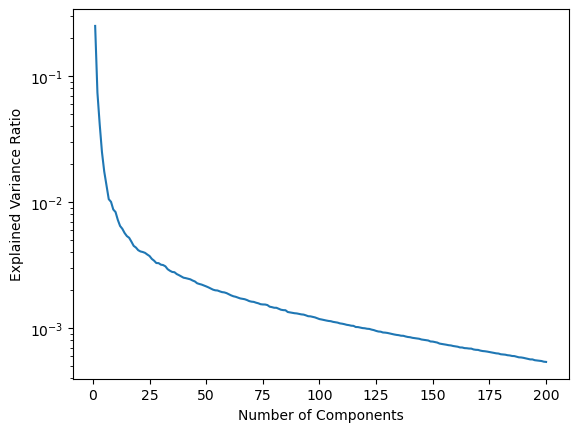

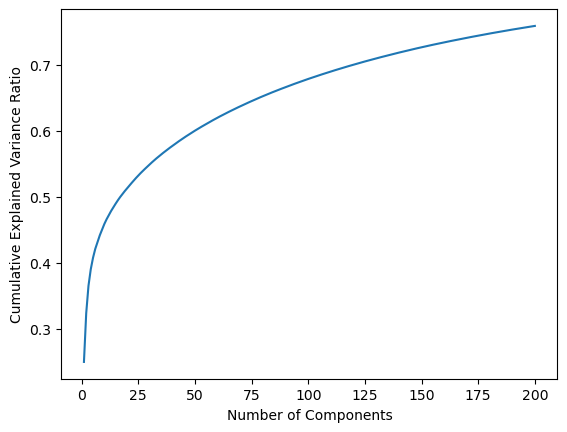

Train Reconstruction error is  0.2406548110936006





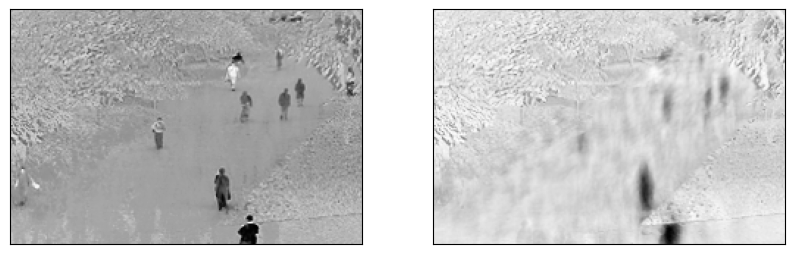

Val Reconstruction error is  1.110493066015581





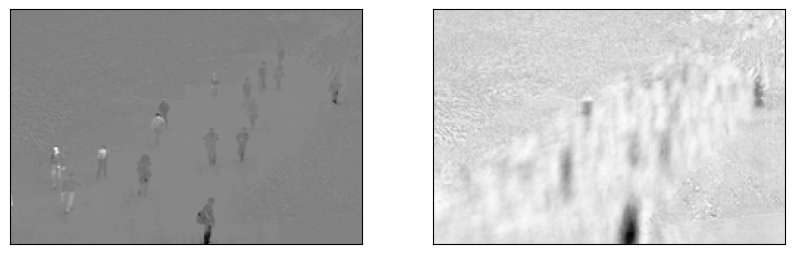

In [16]:

mean = X_train_hyp.mean(axis=0)
std = X_train_hyp.std(axis=0)

x_train_norm = (X_train_hyp - mean) / std
x_val_norm = (X_val_hyp - mean) / std
x_test_norm = (X_test - mean) / std




esn_input_tr_pca, esn_input_val_pca, esn_input_te_pca = do_pca(200, x_train_norm, x_val_norm, x_test_norm)

In [17]:
esn_input_train = esn_input_tr_pca.reshape(42, 200, 200)
esn_input_val = esn_input_val_pca.reshape(14, 200, 200)
esn_input_test = esn_input_te_pca.reshape(14, 200, 200)





[I 2023-05-24 13:59:31,195] A new study created in memory with name: no-name-d7fa051f-191d-4303-b663-ead7fecb75b9


Balanced acc:  0.5075288145069036
F1:  0.06221408966148215
AUC:  0.5075288145069036


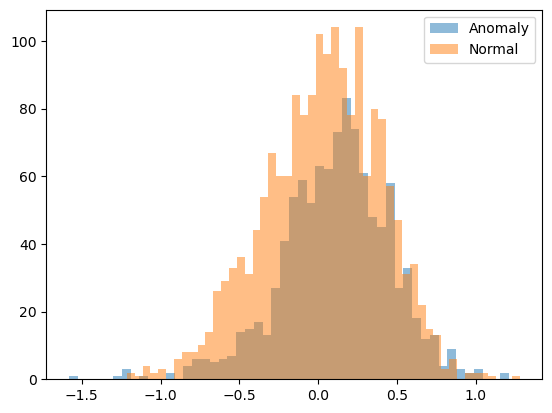

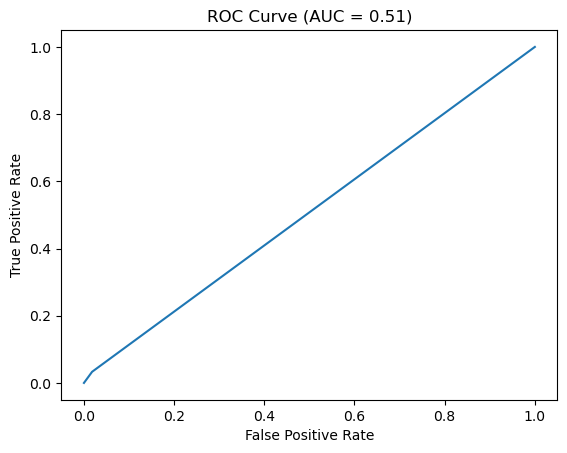

[I 2023-05-24 13:59:47,352] Trial 0 finished with value: 0.06221408966148215 and parameters: {'spectral_radius': 0.7950664443821558, 'sparsity': 0.08795857101531068, 'leaking_rate': 0.930126923183539, 'input_scaling': 4.152467225215867, 'threshold': 0.7173056490438456, 'ridge_alpha': 0.43681521744925744}. Best is trial 0 with value: 0.06221408966148215.


Balanced acc:  0.5487329964615835
F1:  0.5332480818414322
AUC:  0.5487329964615835


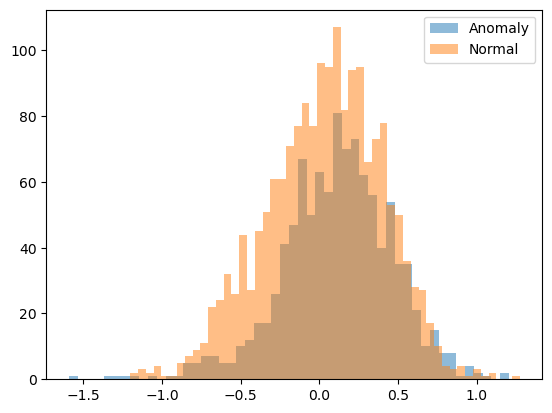

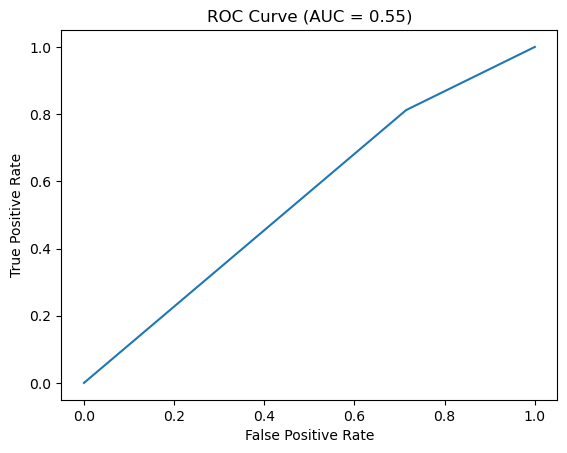

[I 2023-05-24 14:00:03,318] Trial 1 finished with value: 0.5332480818414322 and parameters: {'spectral_radius': 1.4926056726247494, 'sparsity': 0.0623465947551588, 'leaking_rate': 0.8974136864851138, 'input_scaling': 1.1763302332134358, 'threshold': -0.16420134532103403, 'ridge_alpha': 0.5741488728586522}. Best is trial 1 with value: 0.5332480818414322.


Balanced acc:  0.5433545264875985
F1:  0.5055179779280883
AUC:  0.5433545264875985


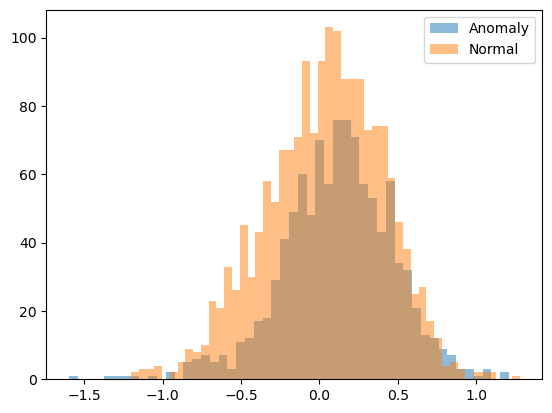

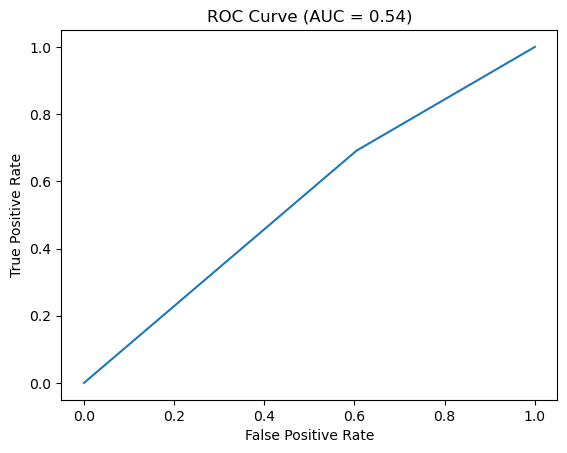

[I 2023-05-24 14:00:19,142] Trial 2 finished with value: 0.5055179779280883 and parameters: {'spectral_radius': 0.3690797990792315, 'sparsity': 0.10206000845758323, 'leaking_rate': 0.8541770221390276, 'input_scaling': 1.163406156679883, 'threshold': -0.041303355877931436, 'ridge_alpha': 0.4609849064941435}. Best is trial 1 with value: 0.5332480818414322.


Balanced acc:  0.5513290068324445
F1:  0.5472038484666266
AUC:  0.5513290068324445


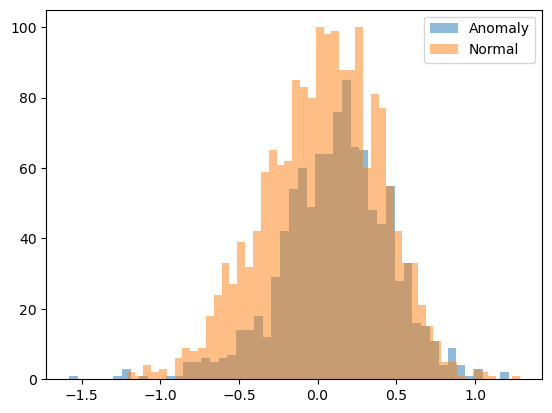

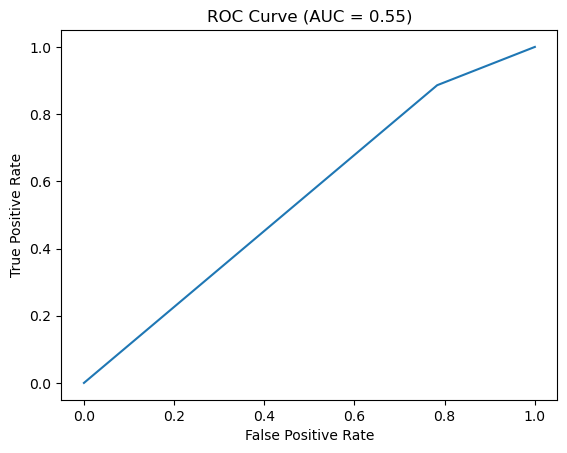

[I 2023-05-24 14:00:34,989] Trial 3 finished with value: 0.5472038484666266 and parameters: {'spectral_radius': 0.9567112659840902, 'sparsity': 0.12059185529597201, 'leaking_rate': 0.9365509169716807, 'input_scaling': 2.750832055335408, 'threshold': -0.2598549391479854, 'ridge_alpha': 0.05513346890560918}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5097508280377907
F1:  0.5366513389234514
AUC:  0.5097508280377907


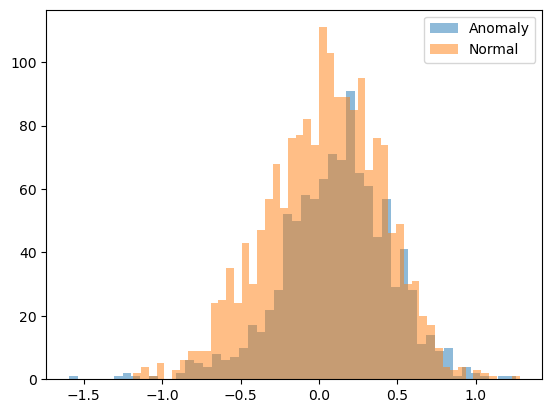

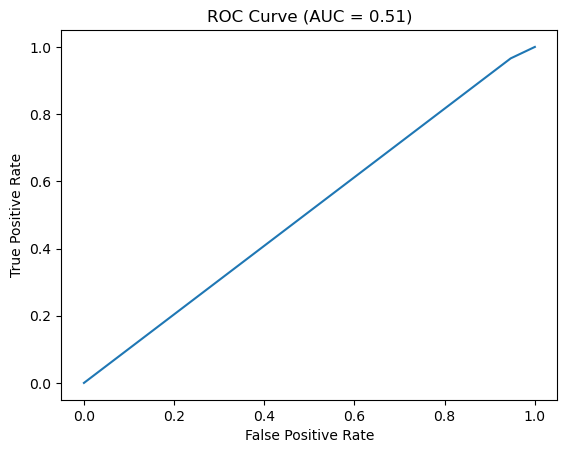

[I 2023-05-24 14:00:50,824] Trial 4 finished with value: 0.5366513389234514 and parameters: {'spectral_radius': 0.14249355783140322, 'sparsity': 0.14828714926987477, 'leaking_rate': 0.9679952398315924, 'input_scaling': 0.8975291427168369, 'threshold': -0.5947404026703151, 'ridge_alpha': 0.020948668784979873}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5003619147100481
F1:  0.5351964144476667
AUC:  0.5003619147100481


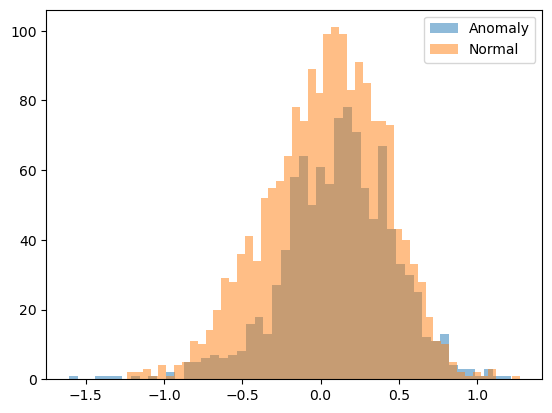

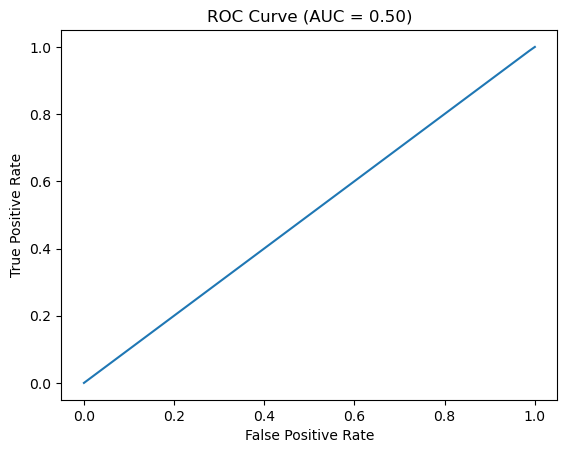

[I 2023-05-24 14:01:06,662] Trial 5 finished with value: 0.5351964144476667 and parameters: {'spectral_radius': 1.4428434105024845, 'sparsity': 0.17422027910035942, 'leaking_rate': 0.7805875119278417, 'input_scaling': 4.041960534799386, 'threshold': -0.835910348031975, 'ridge_alpha': 0.7605133532596614}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.500053271209218
F1:  0.535611038107753
AUC:  0.500053271209218


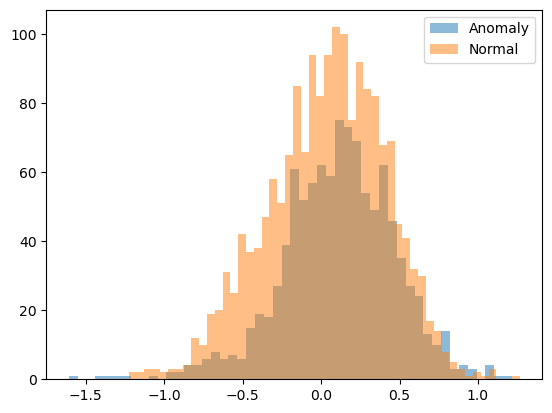

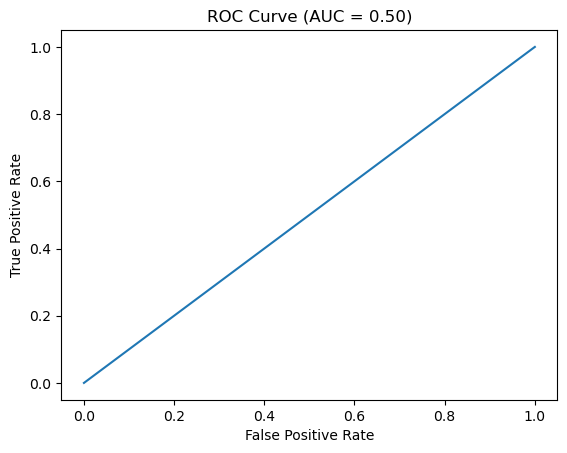

[I 2023-05-24 14:01:22,932] Trial 6 finished with value: 0.535611038107753 and parameters: {'spectral_radius': 0.26566237461596415, 'sparsity': 0.02220803472384585, 'leaking_rate': 0.7609130219790624, 'input_scaling': 2.1009519709131257, 'threshold': -0.9444997256335621, 'ridge_alpha': 0.550931178626945}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5252667542071898
F1:  0.5415968732551647
AUC:  0.5252667542071899


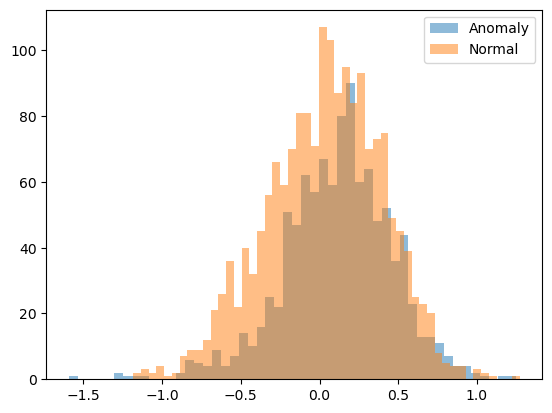

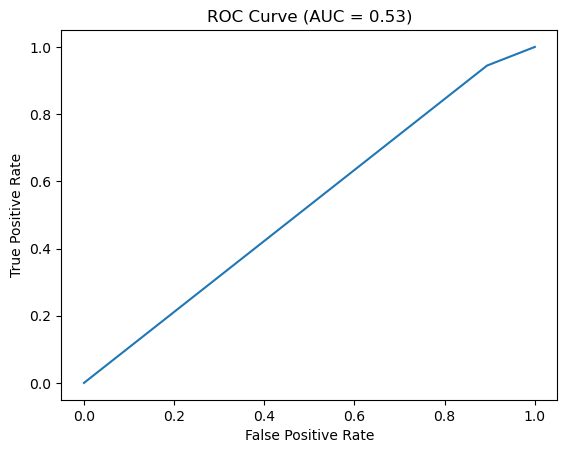

[I 2023-05-24 14:01:39,078] Trial 7 finished with value: 0.5415968732551647 and parameters: {'spectral_radius': 1.2330877319226006, 'sparsity': 0.09030085831320911, 'leaking_rate': 0.9549930124691687, 'input_scaling': 0.8766022984116106, 'threshold': -0.45820337522173915, 'ridge_alpha': 0.6099307492119322}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5526912669815709
F1:  0.5458422174840084
AUC:  0.5526912669815709


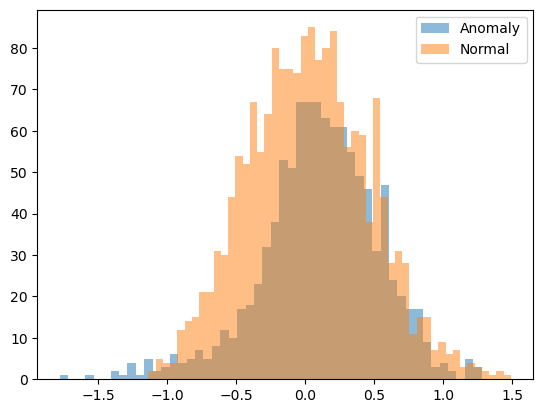

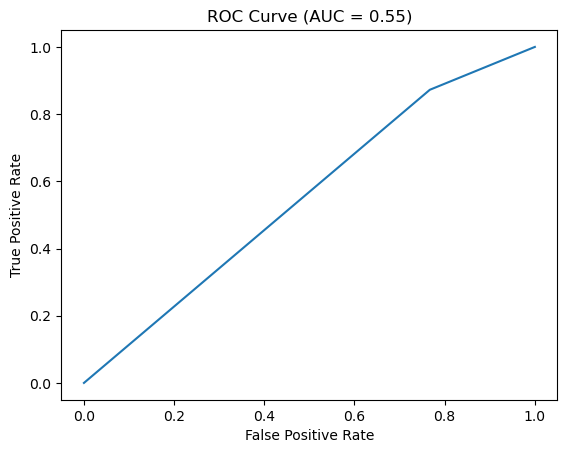

[I 2023-05-24 14:01:55,193] Trial 8 finished with value: 0.5458422174840084 and parameters: {'spectral_radius': 0.3072043343476521, 'sparsity': 0.06822242392615552, 'leaking_rate': 0.9501484228055375, 'input_scaling': 0.02286739527005366, 'threshold': -0.3129748390544558, 'ridge_alpha': 0.006411088740922155}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5291937210269151
F1:  0.5410628019323671
AUC:  0.5291937210269152


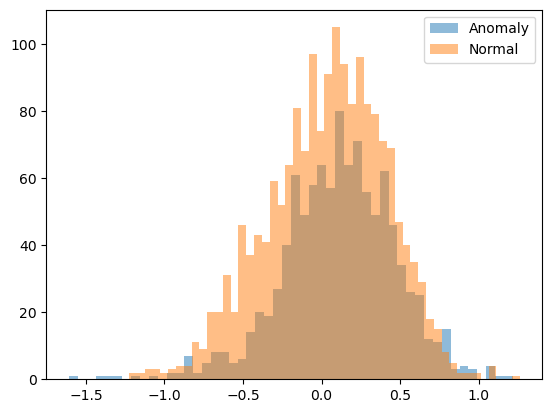

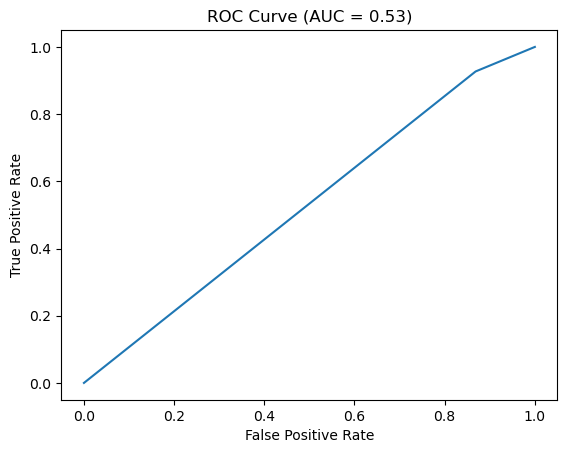

[I 2023-05-24 14:02:11,266] Trial 9 finished with value: 0.5410628019323671 and parameters: {'spectral_radius': 0.31932238536815793, 'sparsity': 0.011676728633194978, 'leaking_rate': 0.7446688781949257, 'input_scaling': 1.5946689392306201, 'threshold': -0.40629829967781084, 'ridge_alpha': 0.6224785989190338}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5193632607691594
F1:  0.32460732984293195
AUC:  0.5193632607691594


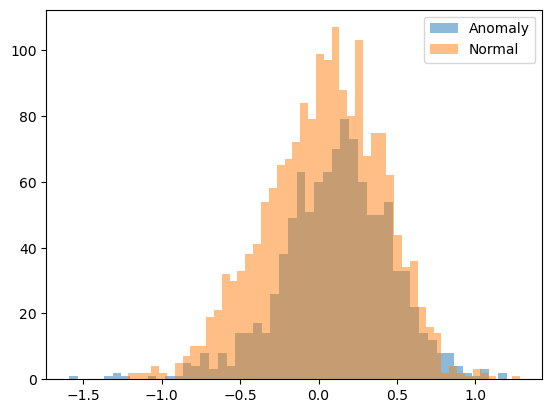

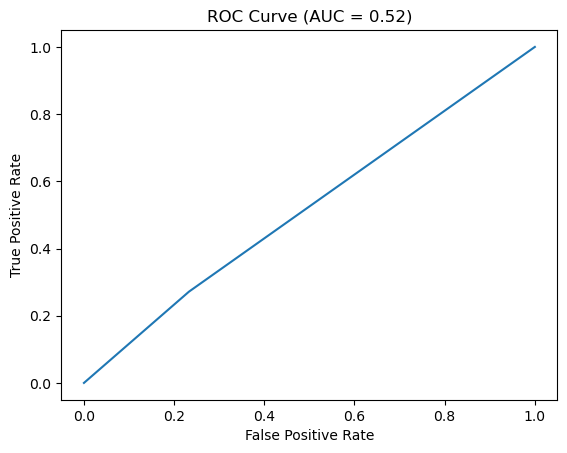

[I 2023-05-24 14:02:28,044] Trial 10 finished with value: 0.32460732984293195 and parameters: {'spectral_radius': 0.906228441535184, 'sparsity': 0.19781928447310085, 'leaking_rate': 0.8721598448822039, 'input_scaling': 2.8294097472576727, 'threshold': 0.31920458167600607, 'ridge_alpha': 0.23073193362132205}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5427498708035879
F1:  0.43278688524590164
AUC:  0.5427498708035879


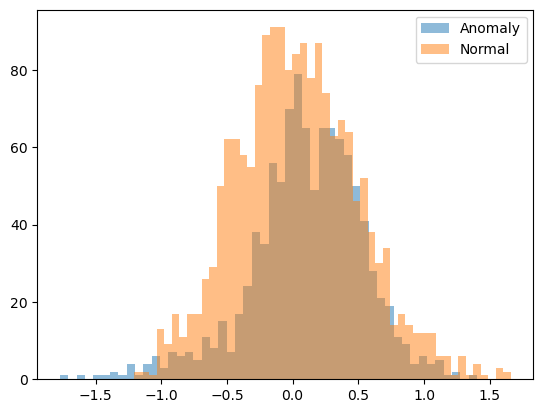

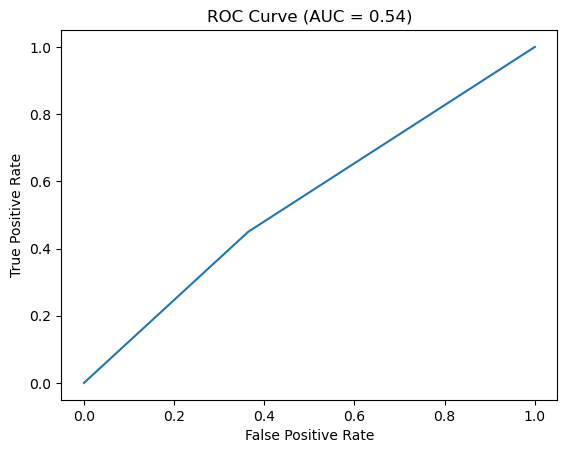

[I 2023-05-24 14:02:43,367] Trial 11 finished with value: 0.43278688524590164 and parameters: {'spectral_radius': 0.6058317538957618, 'sparsity': 0.13378924793036034, 'leaking_rate': 0.9882985012277983, 'input_scaling': 0.01749505396742986, 'threshold': 0.18351490140737642, 'ridge_alpha': 0.018190061832203938}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.556000946799636
F1:  0.5462392108508014
AUC:  0.5560009467996361


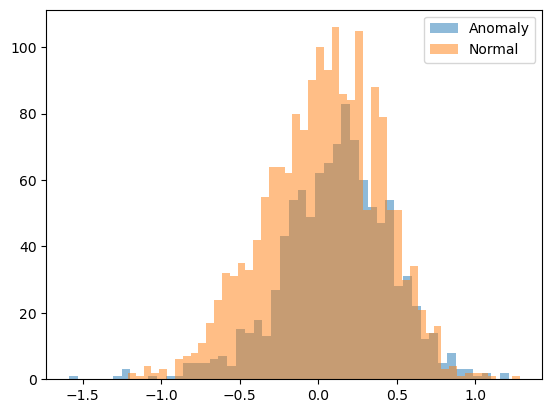

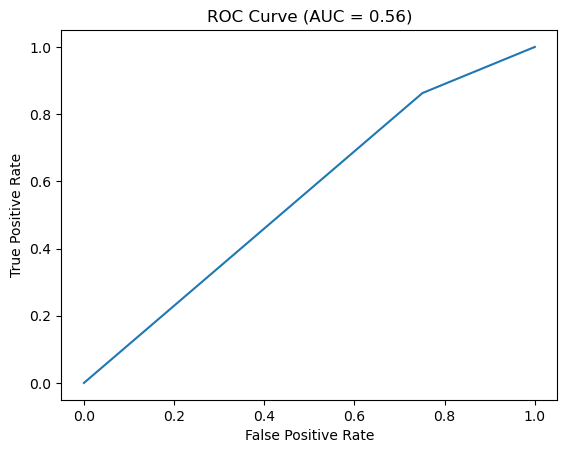

[I 2023-05-24 14:02:59,545] Trial 12 finished with value: 0.5462392108508014 and parameters: {'spectral_radius': 0.004808140880703193, 'sparsity': 0.051712112597817765, 'leaking_rate': 0.9161054691556952, 'input_scaling': 2.8947417824726878, 'threshold': -0.2127152213994627, 'ridge_alpha': 0.18496849582489563}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5476571377104693
F1:  0.4879000780640125
AUC:  0.5476571377104693


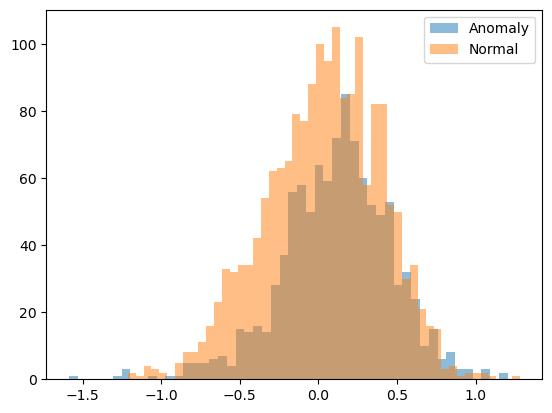

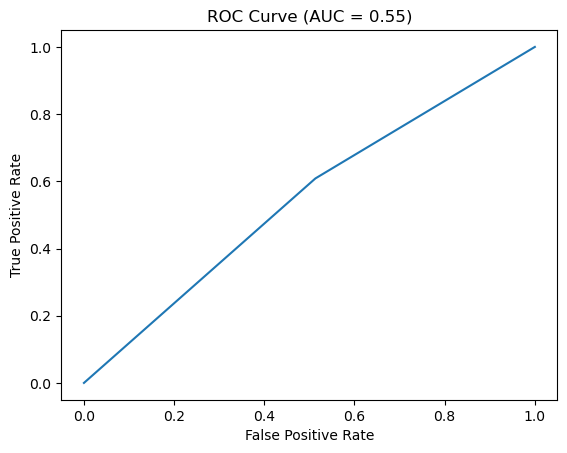

[I 2023-05-24 14:03:15,196] Trial 13 finished with value: 0.4879000780640125 and parameters: {'spectral_radius': 0.017000732667516522, 'sparsity': 0.043468659094948646, 'leaking_rate': 0.9072521879211124, 'input_scaling': 2.822692825158803, 'threshold': 0.04575592351888841, 'ridge_alpha': 0.21317713503323535}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5050577443432291
F1:  0.5351206434316355
AUC:  0.5050577443432291


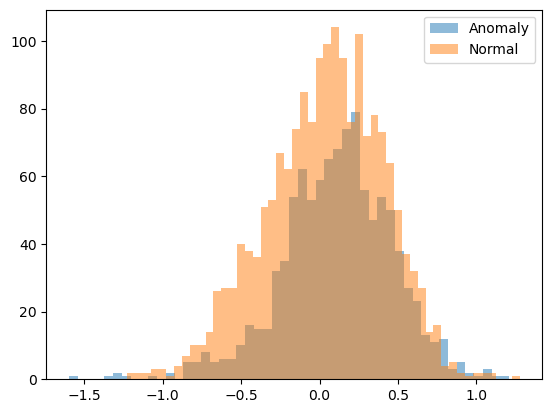

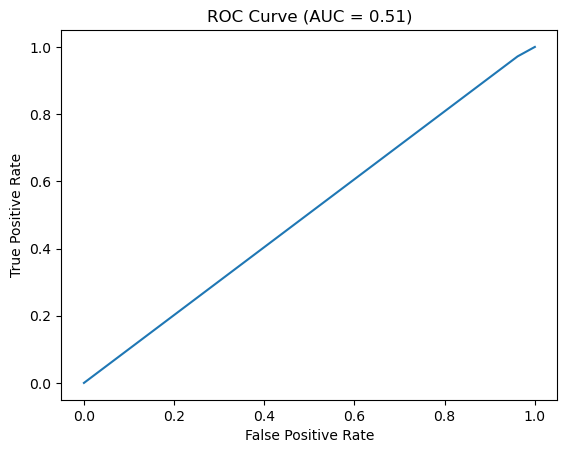

[I 2023-05-24 14:03:30,579] Trial 14 finished with value: 0.5351206434316355 and parameters: {'spectral_radius': 0.5441478203596716, 'sparsity': 0.1248241744116654, 'leaking_rate': 0.8185132640699765, 'input_scaling': 3.391732488836637, 'threshold': -0.6591998568661814, 'ridge_alpha': 0.20736672005343482}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5534362401290371
F1:  0.5453431372549019
AUC:  0.5534362401290371


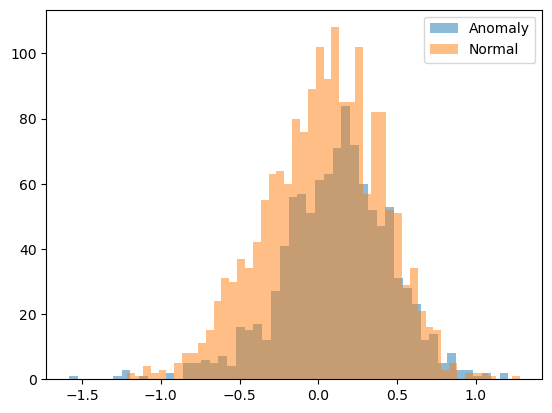

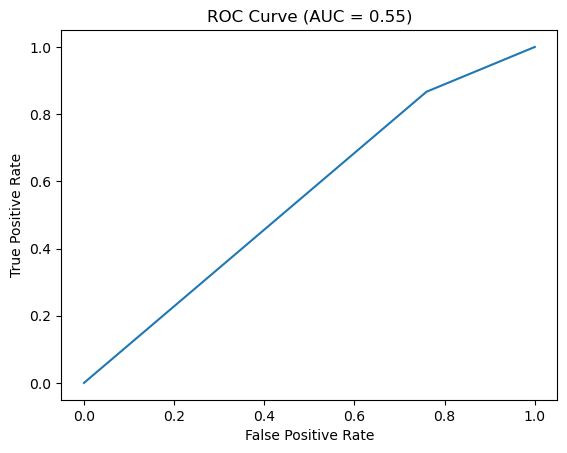

[I 2023-05-24 14:03:46,579] Trial 15 finished with value: 0.5453431372549019 and parameters: {'spectral_radius': 0.976146266978156, 'sparsity': 0.0011029736124211348, 'leaking_rate': 0.9148479966298458, 'input_scaling': 3.4675016446912337, 'threshold': -0.22366061797995046, 'ridge_alpha': 0.9155069068876976}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5158064464753407
F1:  0.3039806996381182
AUC:  0.5158064464753407


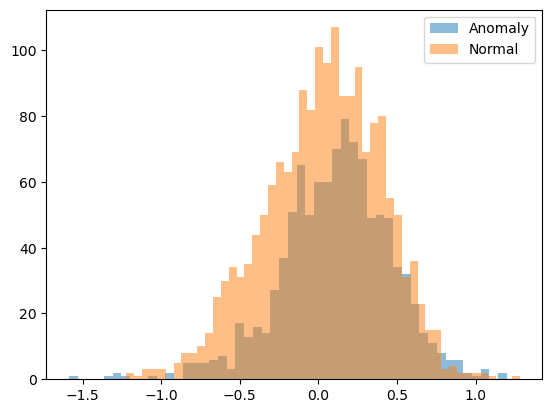

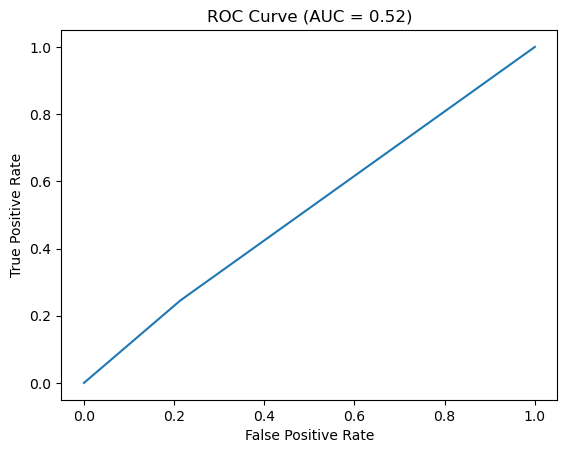

[I 2023-05-24 14:04:02,559] Trial 16 finished with value: 0.3039806996381182 and parameters: {'spectral_radius': 0.6505569600201426, 'sparsity': 0.03822485041060422, 'leaking_rate': 0.8855679171989665, 'input_scaling': 4.8456621528592025, 'threshold': 0.3433049011042533, 'ridge_alpha': 0.3579045944085495}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5465098845552485
F1:  0.5057636887608069
AUC:  0.5465098845552486


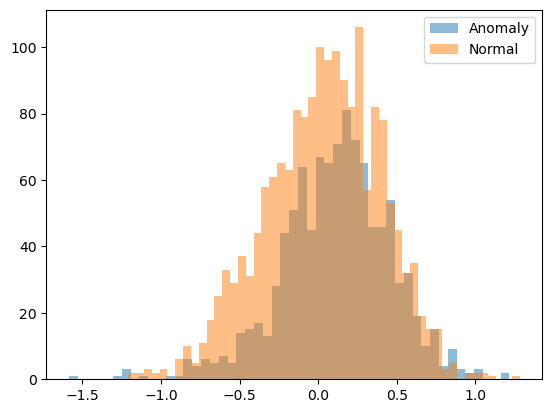

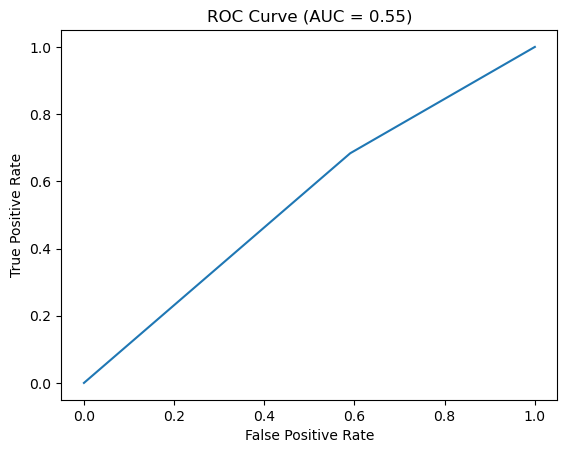

[I 2023-05-24 14:04:18,785] Trial 17 finished with value: 0.5057636887608069 and parameters: {'spectral_radius': 4.995010202528405e-05, 'sparsity': 0.11669048778028415, 'leaking_rate': 0.9289055900865516, 'input_scaling': 2.5155414683653374, 'threshold': -0.027547651774072937, 'ridge_alpha': 0.12550231592053215}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5159816373592638
F1:  0.5393013100436681
AUC:  0.5159816373592637


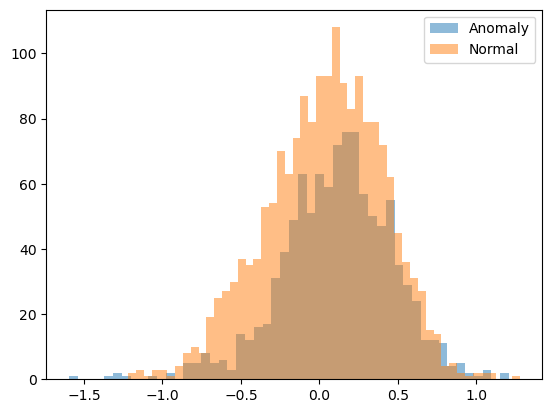

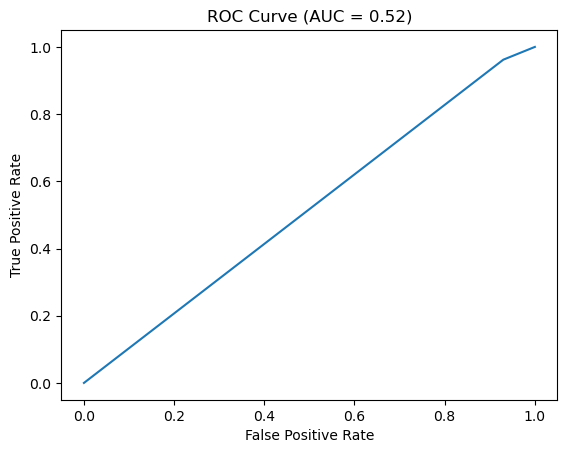

[I 2023-05-24 14:04:35,164] Trial 18 finished with value: 0.5393013100436681 and parameters: {'spectral_radius': 0.5025959902942174, 'sparsity': 0.07293949206797398, 'leaking_rate': 0.8350478368611767, 'input_scaling': 2.166240418814394, 'threshold': -0.5543223311918573, 'ridge_alpha': 0.32592497102544904}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5437386833004645
F1:  0.5438908659549229
AUC:  0.5437386833004644


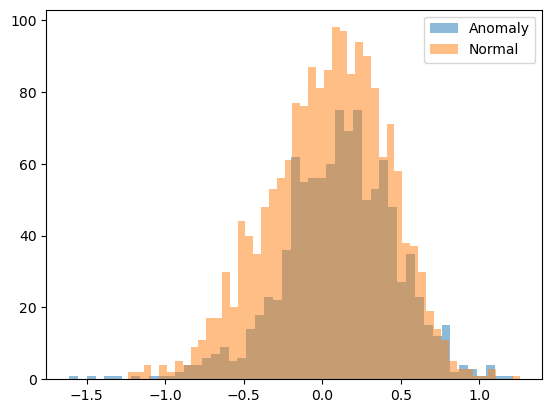

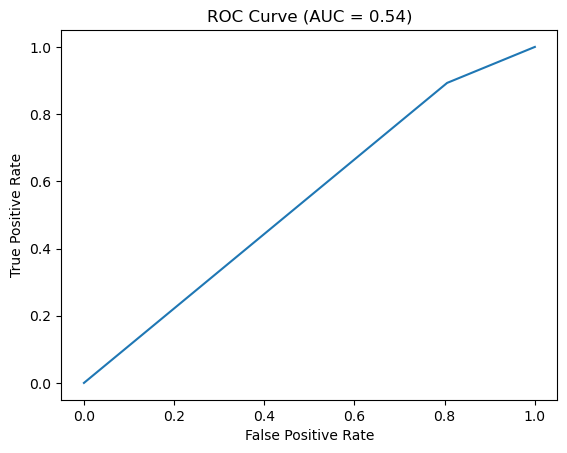

[I 2023-05-24 14:04:51,552] Trial 19 finished with value: 0.5438908659549229 and parameters: {'spectral_radius': 1.0493668501610975, 'sparsity': 0.10606925078040341, 'leaking_rate': 0.7187297169874417, 'input_scaling': 3.2463006262789715, 'threshold': -0.29225478723014936, 'ridge_alpha': 0.13432595770817568}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5054940739898653
F1:  0.5350523771152296
AUC:  0.5054940739898653


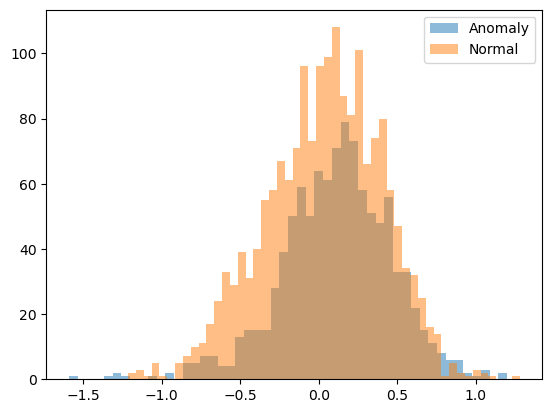

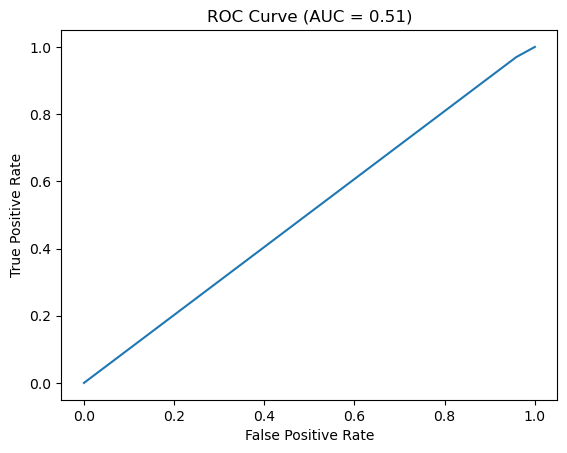

[I 2023-05-24 14:05:08,054] Trial 20 finished with value: 0.5350523771152296 and parameters: {'spectral_radius': 0.755845969013609, 'sparsity': 0.04513021432935478, 'leaking_rate': 0.8693103671263, 'input_scaling': 2.1451713154281666, 'threshold': -0.6438684117683315, 'ridge_alpha': 0.32399818453916}. Best is trial 3 with value: 0.5472038484666266.


Balanced acc:  0.5521245052505093
F1:  0.5472096530920061
AUC:  0.5521245052505093


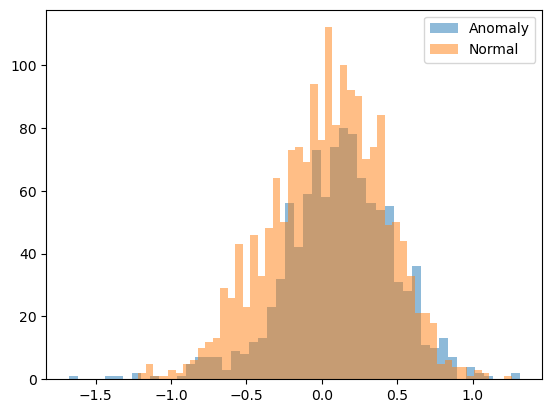

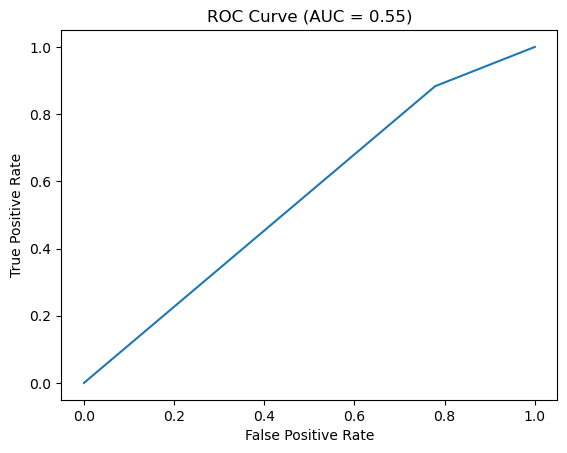

[I 2023-05-24 14:05:24,328] Trial 21 finished with value: 0.5472096530920061 and parameters: {'spectral_radius': 0.13269922318822394, 'sparsity': 0.07007870304659279, 'leaking_rate': 0.9469393320639427, 'input_scaling': 0.23576138591632556, 'threshold': -0.2610448567419277, 'ridge_alpha': 0.011186996262390614}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5507548310671102
F1:  0.5368787591009814
AUC:  0.5507548310671102


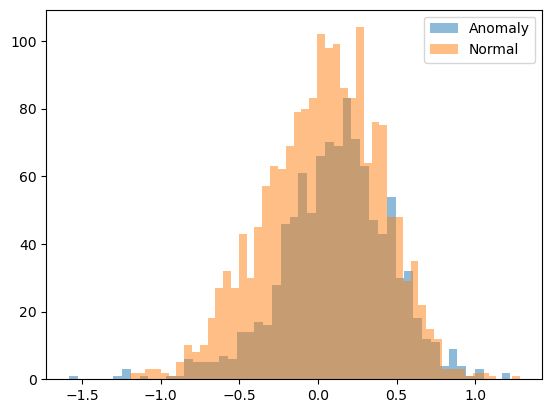

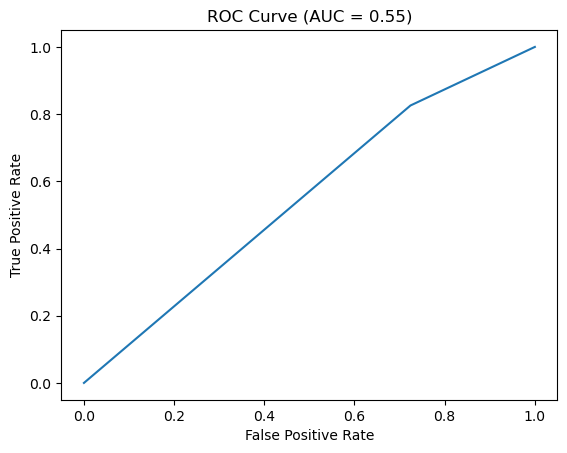

[I 2023-05-24 14:05:40,617] Trial 22 finished with value: 0.5368787591009814 and parameters: {'spectral_radius': 0.17715736720843428, 'sparsity': 0.08116392062418715, 'leaking_rate': 0.9392175070715147, 'input_scaling': 1.737985200266118, 'threshold': -0.17548102088141843, 'ridge_alpha': 0.09412514154991787}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5278342068164081
F1:  0.5407701019252548
AUC:  0.5278342068164081


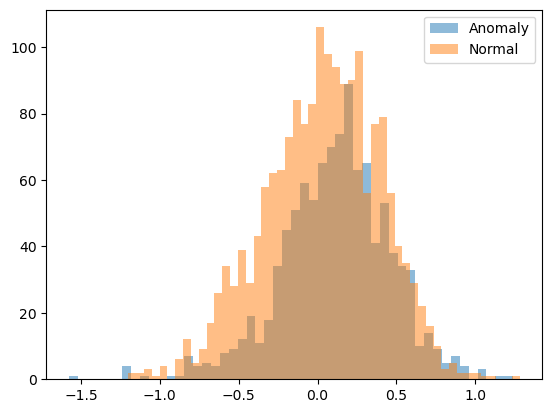

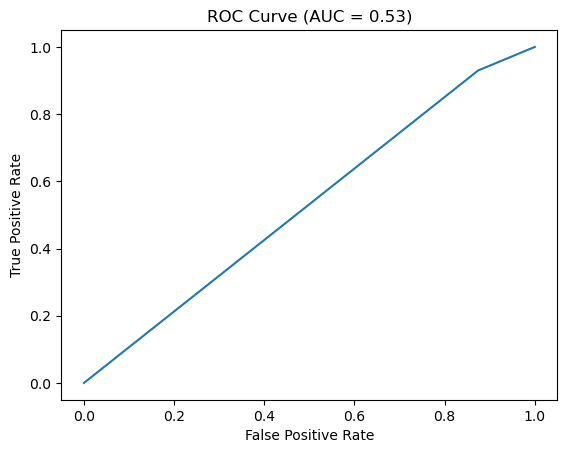

[I 2023-05-24 14:05:56,515] Trial 23 finished with value: 0.5407701019252548 and parameters: {'spectral_radius': 0.45056314066006353, 'sparsity': 0.056082143820763125, 'leaking_rate': 0.9800609963981268, 'input_scaling': 2.606832094902897, 'threshold': -0.4010098082740463, 'ridge_alpha': 0.10158531222723521}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5514998042145765
F1:  0.5363057324840764
AUC:  0.5514998042145765


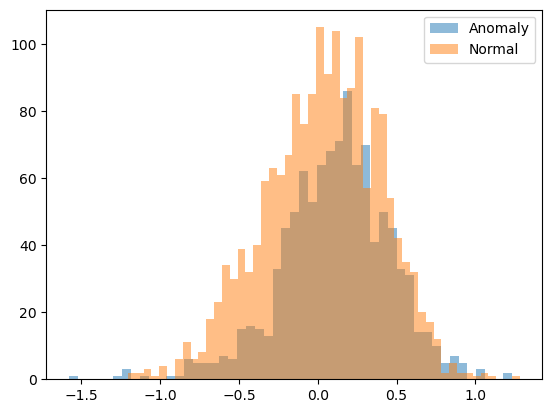

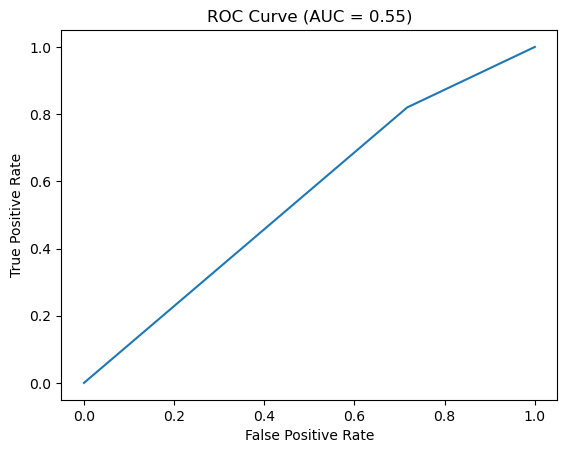

[I 2023-05-24 14:06:13,227] Trial 24 finished with value: 0.5363057324840764 and parameters: {'spectral_radius': 0.1699888740032625, 'sparsity': 0.08176667324058191, 'leaking_rate': 0.9587075470296558, 'input_scaling': 3.0288896077835537, 'threshold': -0.1658235279340754, 'ridge_alpha': 0.00397180424704216}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5236252321004617
F1:  0.5411568409343716
AUC:  0.5236252321004617


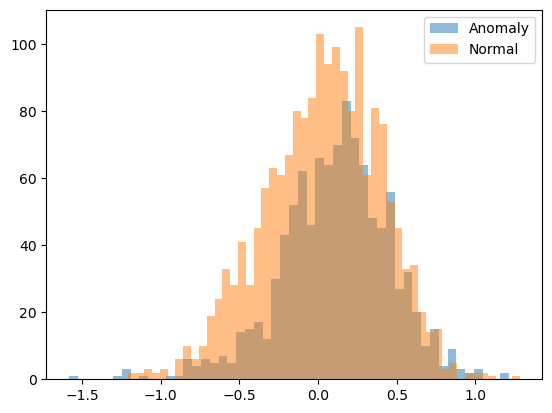

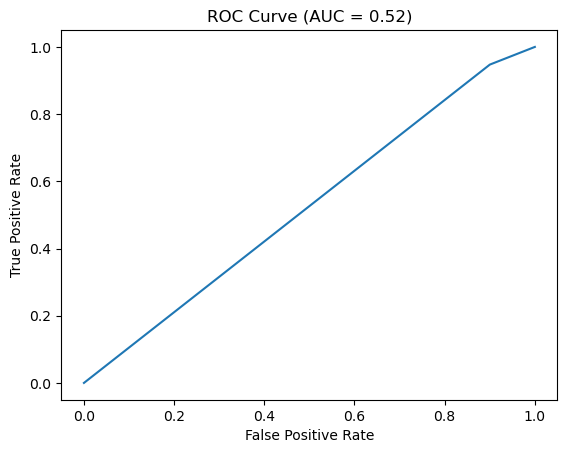

[I 2023-05-24 14:06:29,519] Trial 25 finished with value: 0.5411568409343716 and parameters: {'spectral_radius': 0.13340712103269267, 'sparsity': 0.09889850974742576, 'leaking_rate': 0.926502019190743, 'input_scaling': 2.389122889707609, 'threshold': -0.4713233888208199, 'ridge_alpha': 0.18341639972738003}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5008248799612932
F1:  0.5345695364238411
AUC:  0.5008248799612932


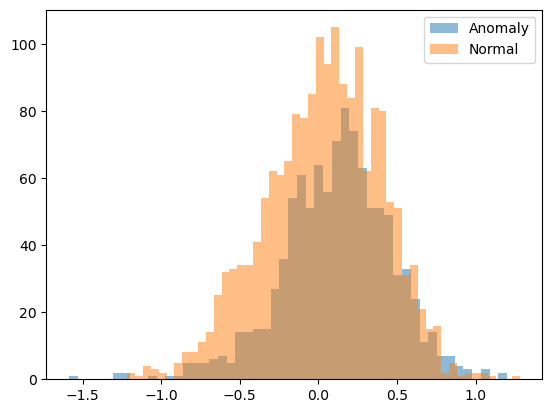

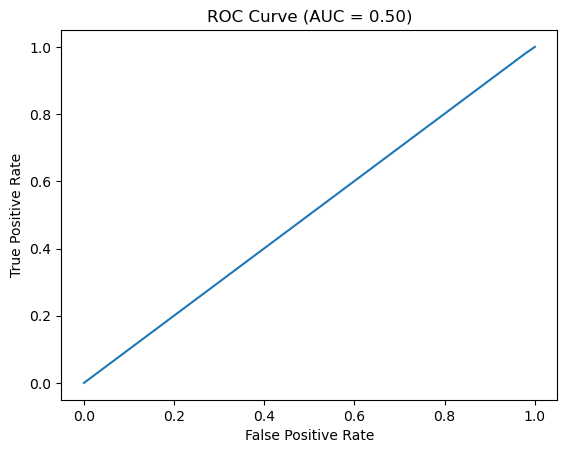

[I 2023-05-24 14:06:45,861] Trial 26 finished with value: 0.5345695364238411 and parameters: {'spectral_radius': 0.4691852691896606, 'sparsity': 0.05712673094897354, 'leaking_rate': 0.9024704595841553, 'input_scaling': 2.9149096133732417, 'threshold': -0.7612953221440074, 'ridge_alpha': 0.08504985670814312}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.543836987903042
F1:  0.5465184318314804
AUC:  0.543836987903042


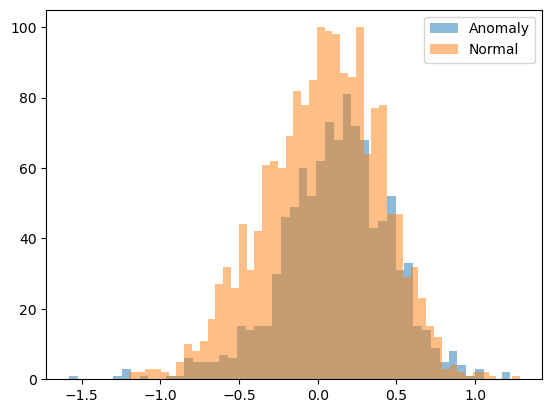

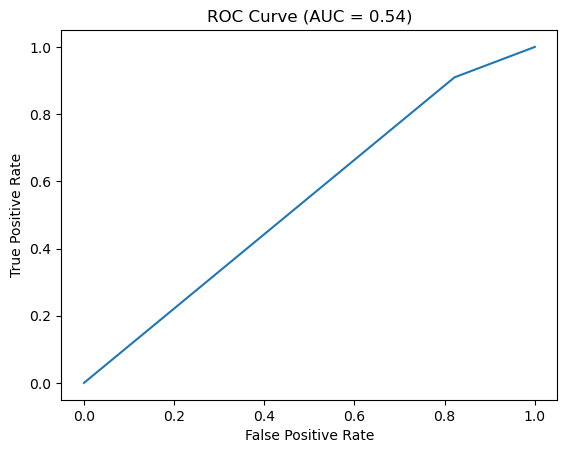

[I 2023-05-24 14:07:02,054] Trial 27 finished with value: 0.5465184318314804 and parameters: {'spectral_radius': 0.662368448147372, 'sparsity': 0.032674423499068954, 'leaking_rate': 0.9458779332327889, 'input_scaling': 1.7444048735679427, 'threshold': -0.3122645473374015, 'ridge_alpha': 0.26287807666069507}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5004629652512451
F1:  0.5360987135731163
AUC:  0.5004629652512451


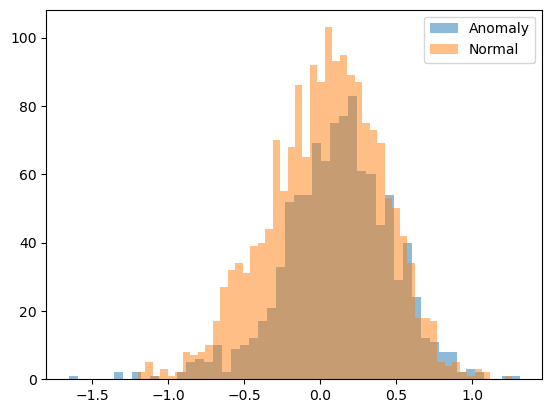

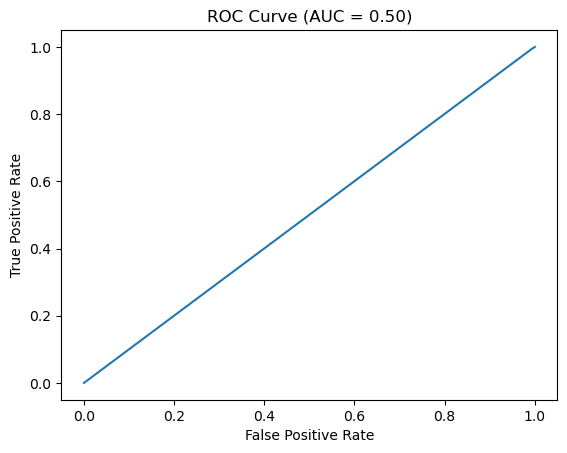

[I 2023-05-24 14:07:18,358] Trial 28 finished with value: 0.5360987135731163 and parameters: {'spectral_radius': 0.6654160565657289, 'sparsity': 0.0250695246668323, 'leaking_rate': 0.9739692091402578, 'input_scaling': 0.3144881941017461, 'threshold': -0.9962634634854957, 'ridge_alpha': 0.25506544066778025}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5077575511939066
F1:  0.07540394973070018
AUC:  0.5077575511939066


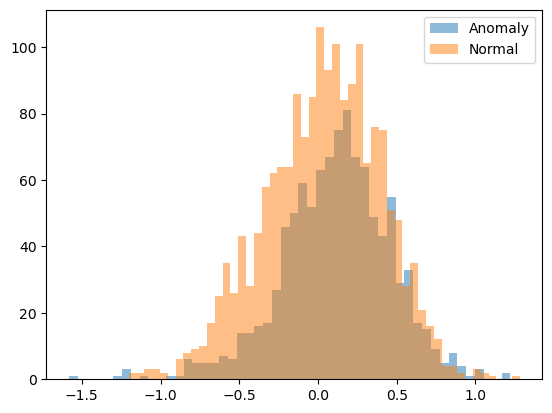

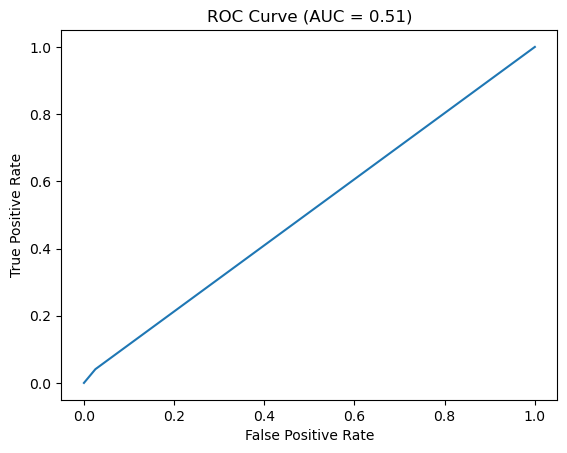

[I 2023-05-24 14:07:34,712] Trial 29 finished with value: 0.07540394973070018 and parameters: {'spectral_radius': 0.8429605162758049, 'sparsity': 0.07309439448231543, 'leaking_rate': 0.9394075505294104, 'input_scaling': 1.7850813771863705, 'threshold': 0.685389366628901, 'ridge_alpha': 0.3917738763789771}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5365791975378816
F1:  0.5439354652837799
AUC:  0.5365791975378815


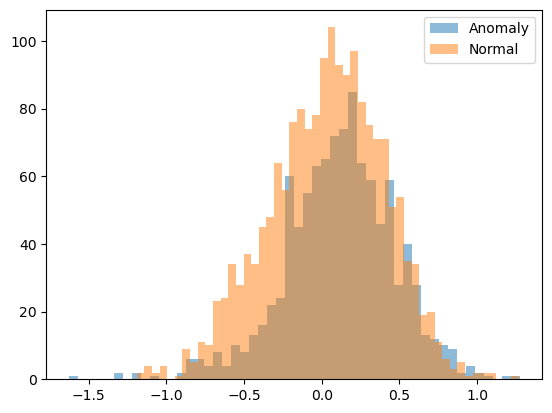

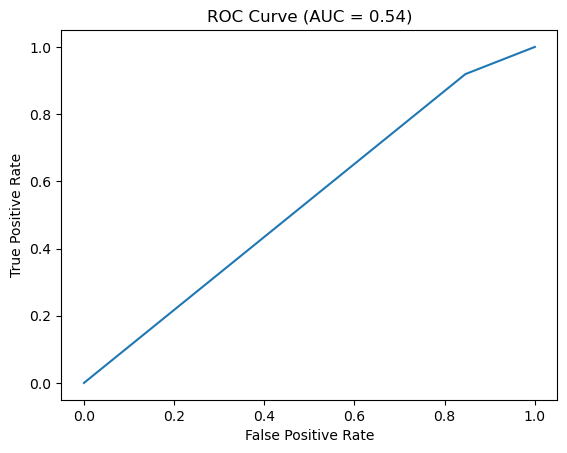

[I 2023-05-24 14:07:51,049] Trial 30 finished with value: 0.5439354652837799 and parameters: {'spectral_radius': 0.7452533975997175, 'sparsity': 0.03217320831754593, 'leaking_rate': 0.949111139116127, 'input_scaling': 0.4707312257827523, 'threshold': -0.3535744596517926, 'ridge_alpha': 0.3059982791230651}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5468141345542875
F1:  0.5462633451957296
AUC:  0.5468141345542875


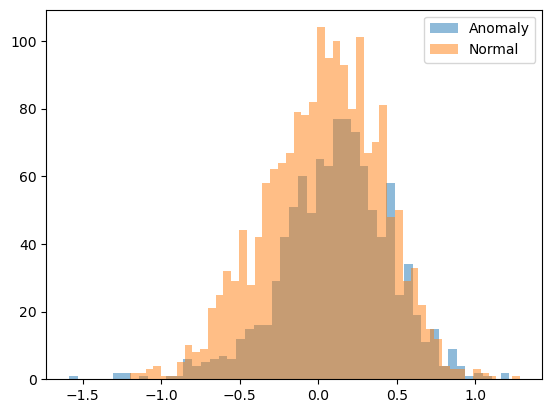

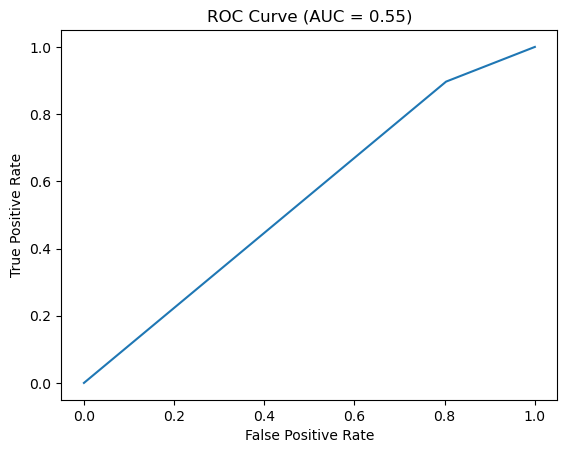

[I 2023-05-24 14:08:07,366] Trial 31 finished with value: 0.5462633451957296 and parameters: {'spectral_radius': 0.4191923136656248, 'sparsity': 0.05142474672468319, 'leaking_rate': 0.9237684962416697, 'input_scaling': 1.506523271413987, 'threshold': -0.2823032507129128, 'ridge_alpha': 0.1454131975102056}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5186740301756687
F1:  0.5404220334338175
AUC:  0.5186740301756687


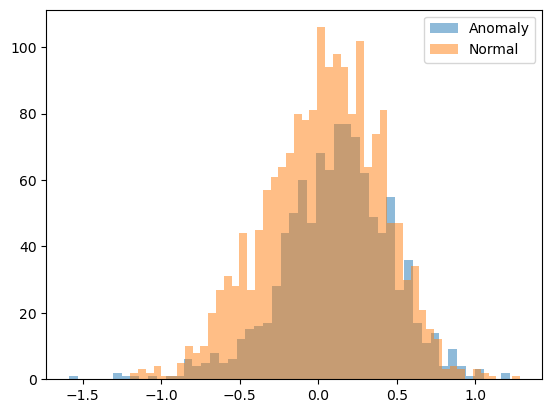

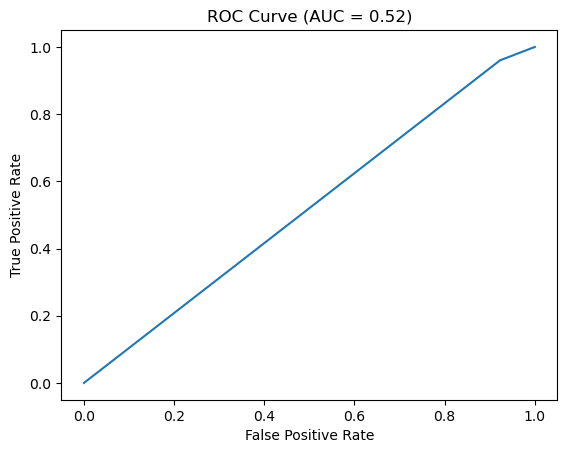

[I 2023-05-24 14:08:23,762] Trial 32 finished with value: 0.5404220334338175 and parameters: {'spectral_radius': 0.3973398408998509, 'sparsity': 0.06551083061705115, 'leaking_rate': 0.9264339327576699, 'input_scaling': 1.40946999264666, 'threshold': -0.5312295437174377, 'ridge_alpha': 0.0632454647248338}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5528491584521913
F1:  0.5253549695740365
AUC:  0.5528491584521913


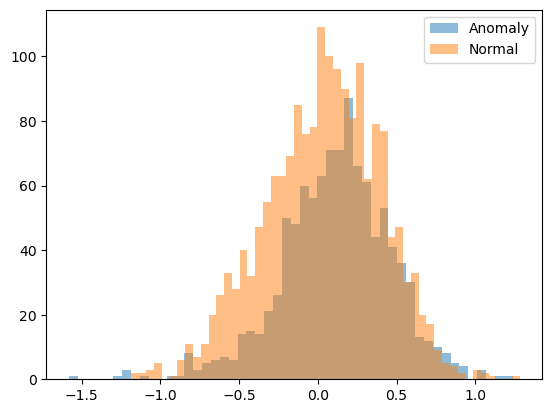

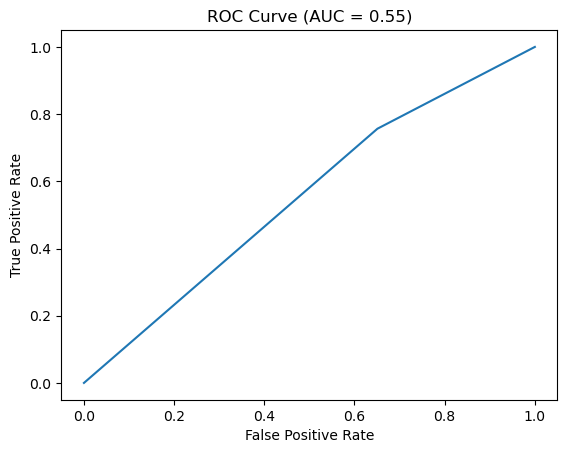

[I 2023-05-24 14:08:40,367] Trial 33 finished with value: 0.5253549695740365 and parameters: {'spectral_radius': 0.6097719693829651, 'sparsity': 0.045557416807105004, 'leaking_rate': 0.9647528824998426, 'input_scaling': 1.2944745793431958, 'threshold': -0.09589764875204962, 'ridge_alpha': 0.15023796893136507}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5448134436761308
F1:  0.5457227138643067
AUC:  0.5448134436761308


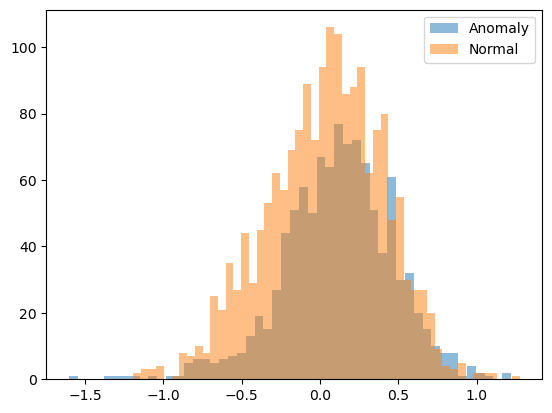

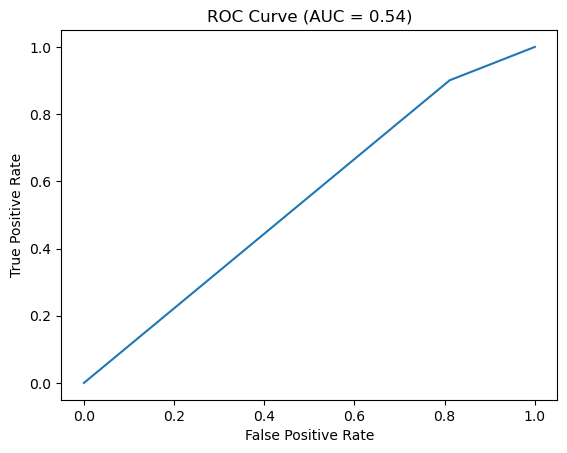

[I 2023-05-24 14:08:56,789] Trial 34 finished with value: 0.5457227138643067 and parameters: {'spectral_radius': 0.39735030081930545, 'sparsity': 0.032036330868325996, 'leaking_rate': 0.8945895871286782, 'input_scaling': 0.7978162947268757, 'threshold': -0.2953994858527889, 'ridge_alpha': 0.05915437928848073}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5482653631146852
F1:  0.5183407610558793
AUC:  0.5482653631146852


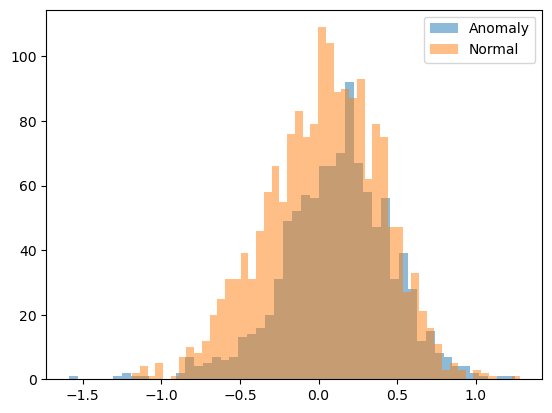

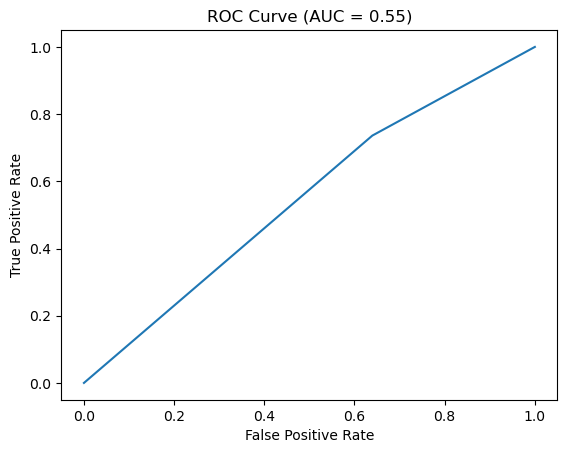

[I 2023-05-24 14:09:13,168] Trial 35 finished with value: 0.5183407610558793 and parameters: {'spectral_radius': 0.5581489987321624, 'sparsity': 0.05680022201824776, 'leaking_rate': 0.9716633558808643, 'input_scaling': 1.0326322334765843, 'threshold': -0.08008644333201403, 'ridge_alpha': 0.2712580841602048}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5252667542071898
F1:  0.5415968732551647
AUC:  0.5252667542071899


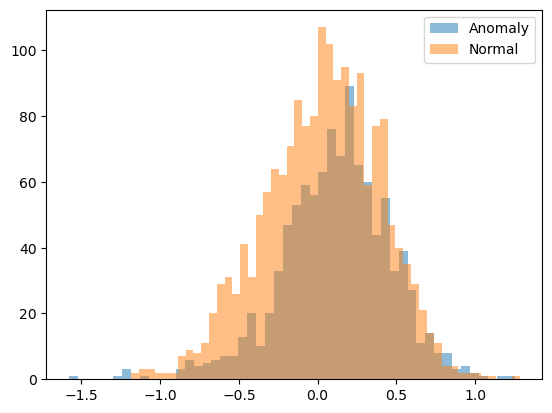

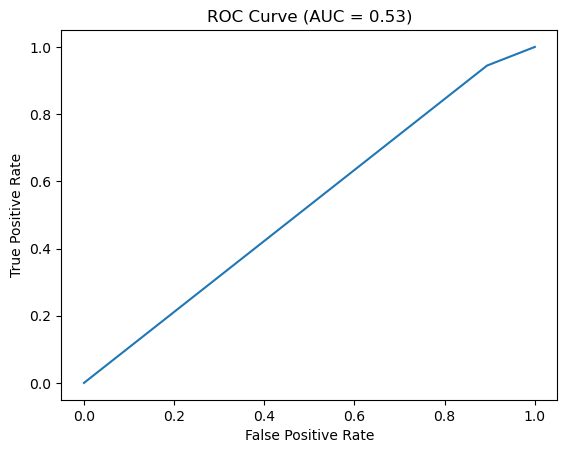

[I 2023-05-24 14:09:29,552] Trial 36 finished with value: 0.5415968732551647 and parameters: {'spectral_radius': 0.23580503864595095, 'sparsity': 0.09457739718340884, 'leaking_rate': 0.9896501737305698, 'input_scaling': 1.4337062050230638, 'threshold': -0.4533468623997475, 'ridge_alpha': 0.14573457914415025}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5504829831437812
F1:  0.5467107239411234
AUC:  0.5504829831437812


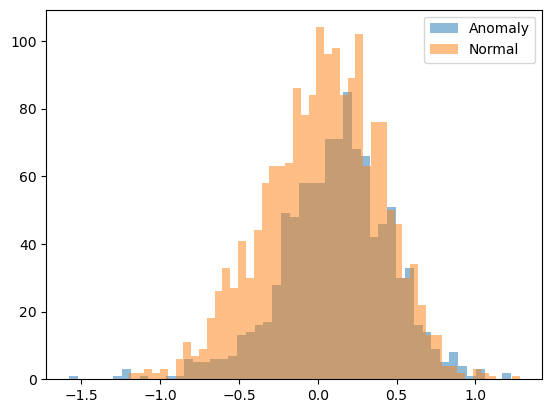

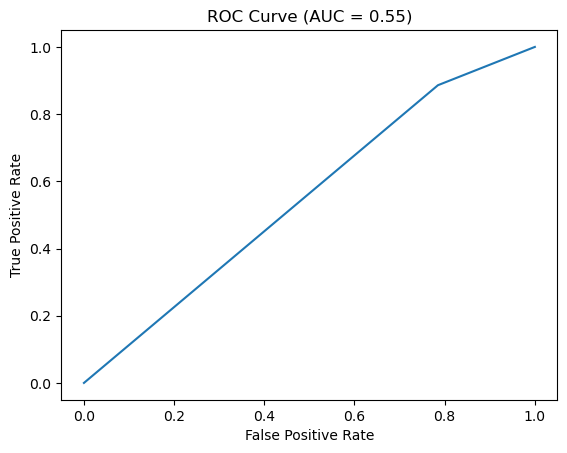

[I 2023-05-24 14:09:45,902] Trial 37 finished with value: 0.5467107239411234 and parameters: {'spectral_radius': 0.7178663779660783, 'sparsity': 0.078075097648005, 'leaking_rate': 0.9494469591181455, 'input_scaling': 1.854246283762921, 'threshold': -0.261029675960601, 'ridge_alpha': 0.0678321438126314}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5315030554059019
F1:  0.5411292633992548
AUC:  0.5315030554059018


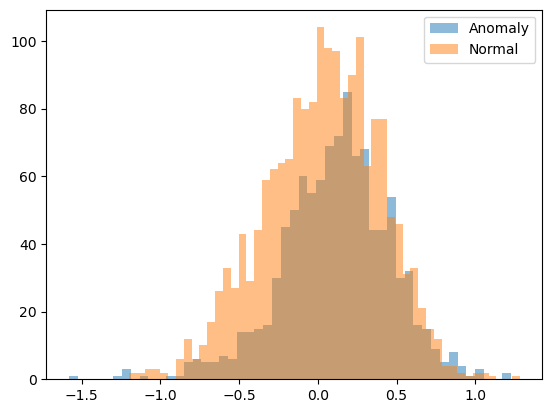

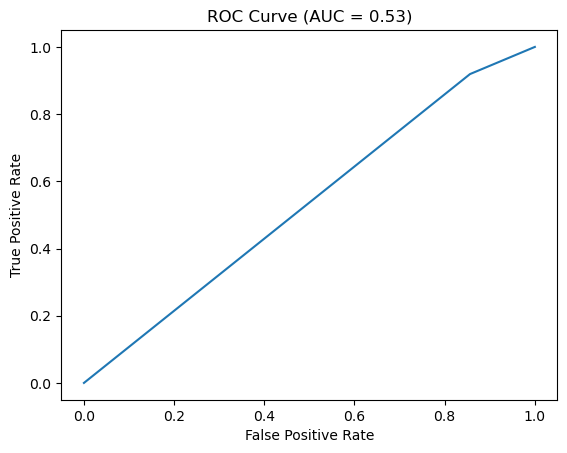

[I 2023-05-24 14:10:02,162] Trial 38 finished with value: 0.5411292633992548 and parameters: {'spectral_radius': 0.7003140140021968, 'sparsity': 0.08697614749064073, 'leaking_rate': 0.9448610817079491, 'input_scaling': 1.936097435192739, 'threshold': -0.3658831886687273, 'ridge_alpha': 0.060921043178331274}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5489183473183987
F1:  0.4834198961246504
AUC:  0.5489183473183987


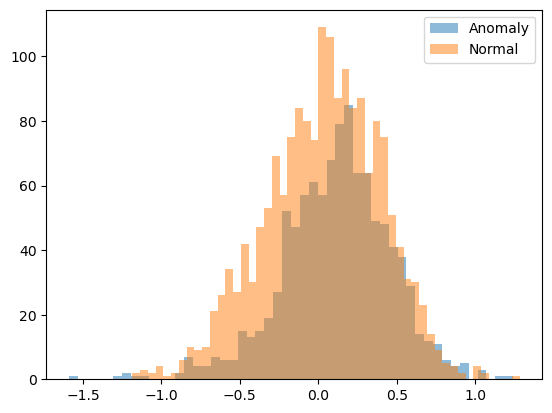

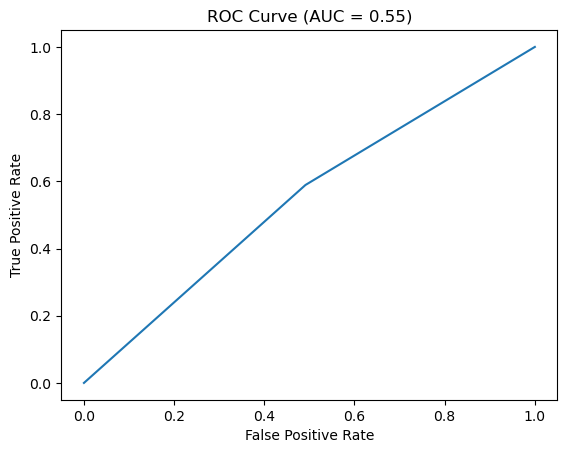

[I 2023-05-24 14:10:18,496] Trial 39 finished with value: 0.4834198961246504 and parameters: {'spectral_radius': 0.8218826597283472, 'sparsity': 0.10831369976537442, 'leaking_rate': 0.9641882204997215, 'input_scaling': 1.169990265717073, 'threshold': 0.06595587125685254, 'ridge_alpha': 0.006781998129436028}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5488799041777259
F1:  0.5193294560383168
AUC:  0.5488799041777259


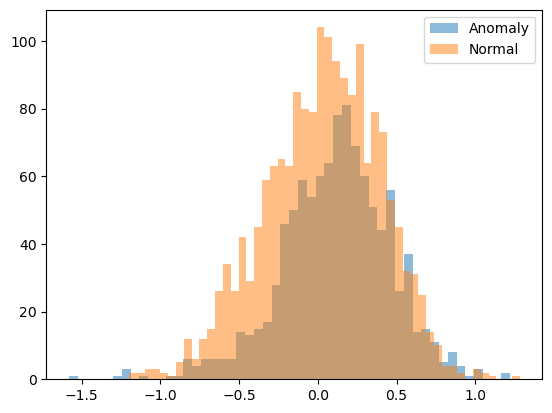

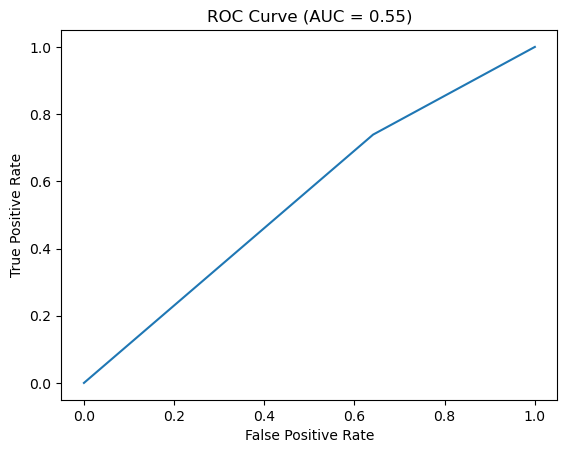

[I 2023-05-24 14:10:34,789] Trial 40 finished with value: 0.5193294560383168 and parameters: {'spectral_radius': 1.0416872435214777, 'sparsity': 0.09264547721396751, 'leaking_rate': 0.9384504517807627, 'input_scaling': 1.9596090516893414, 'threshold': -0.08231046121227448, 'ridge_alpha': 0.05964733410864165}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5498684420807405
F1:  0.5458922660246764
AUC:  0.5498684420807405


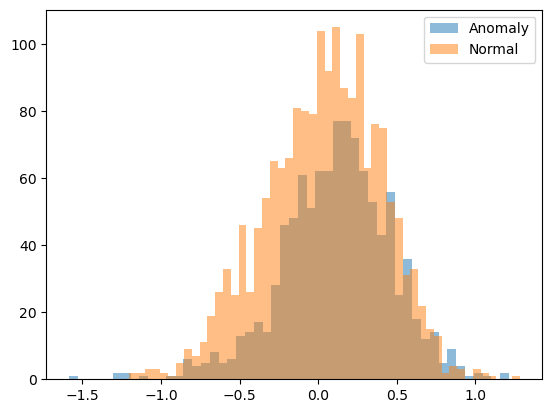

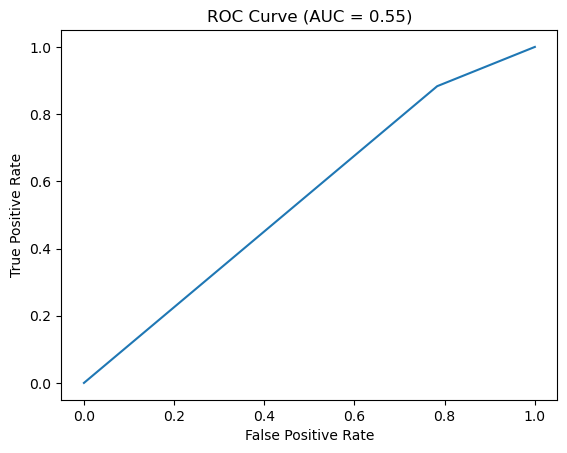

[I 2023-05-24 14:10:51,198] Trial 41 finished with value: 0.5458922660246764 and parameters: {'spectral_radius': 0.7566487689056219, 'sparsity': 0.06482780808108335, 'leaking_rate': 0.922129422517736, 'input_scaling': 1.6923048966070797, 'threshold': -0.2574033282995436, 'ridge_alpha': 0.15453836880951616}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5448134436761308
F1:  0.5457227138643067
AUC:  0.5448134436761308


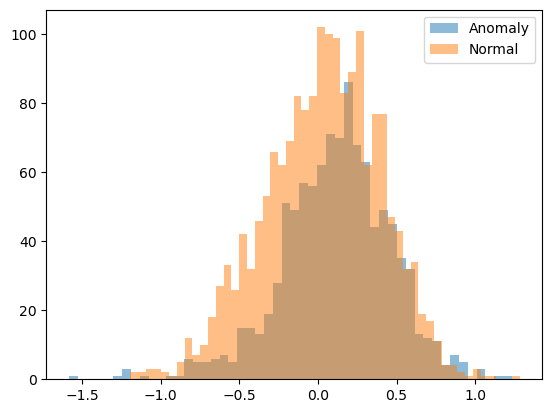

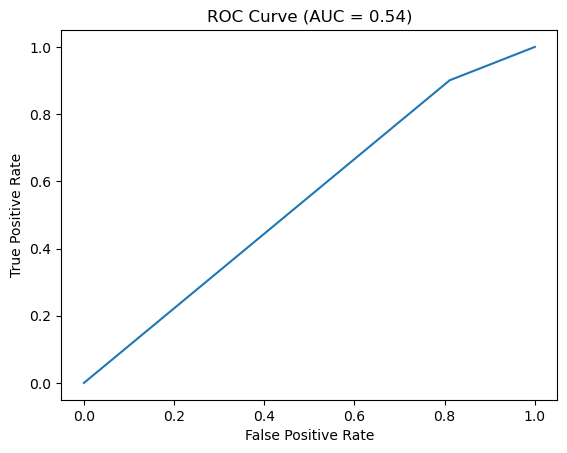

[I 2023-05-24 14:11:07,562] Trial 42 finished with value: 0.5457227138643067 and parameters: {'spectral_radius': 0.37903165547371187, 'sparsity': 0.07384650049674224, 'leaking_rate': 0.9576907267783376, 'input_scaling': 1.5464828082569948, 'threshold': -0.29038440951838224, 'ridge_alpha': 0.11024871025088553}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5513243387367913
F1:  0.533419438165967
AUC:  0.5513243387367913


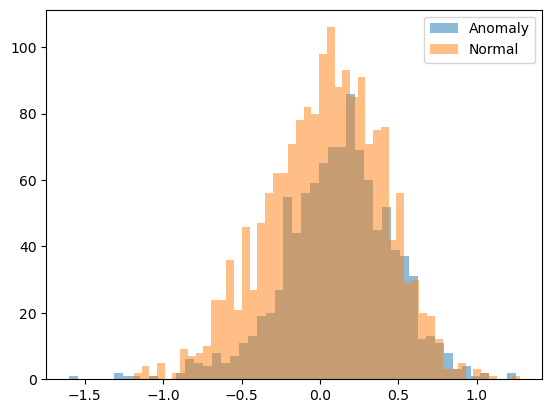

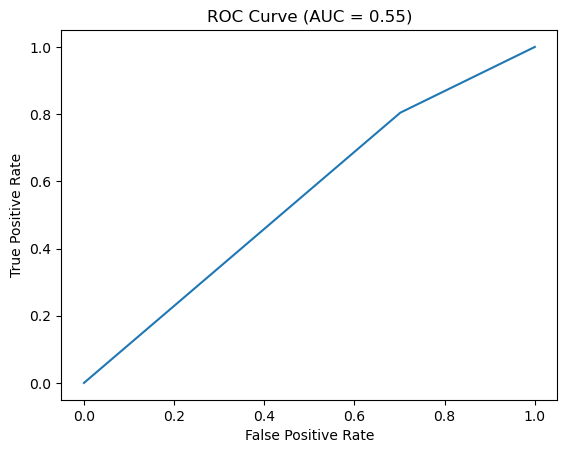

[I 2023-05-24 14:11:23,896] Trial 43 finished with value: 0.533419438165967 and parameters: {'spectral_radius': 0.32013859859860216, 'sparsity': 0.05069160958704601, 'leaking_rate': 0.9486169956981645, 'input_scaling': 0.7465871513050186, 'threshold': -0.15092454601887145, 'ridge_alpha': 0.24483849391758886}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5220342352643323
F1:  0.5411829740187949
AUC:  0.5220342352643322


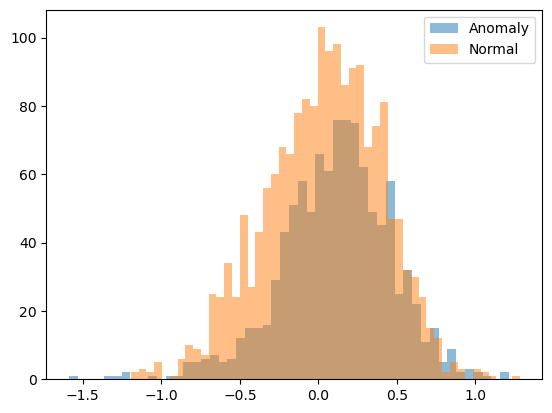

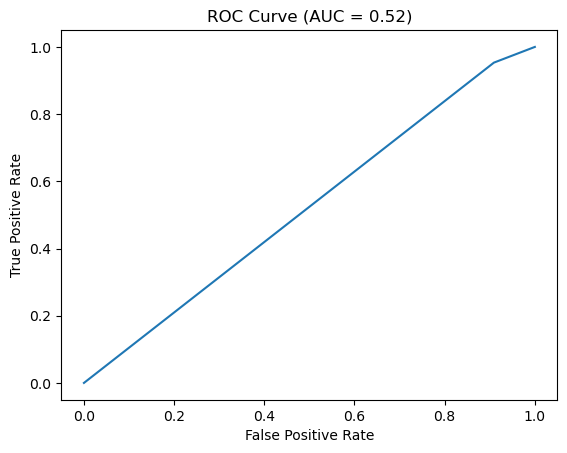

[I 2023-05-24 14:11:40,232] Trial 44 finished with value: 0.5411829740187949 and parameters: {'spectral_radius': 0.5399062258663689, 'sparsity': 0.019757755070572022, 'leaking_rate': 0.9085457805713957, 'input_scaling': 1.310012593249764, 'threshold': -0.48808033833094266, 'ridge_alpha': 0.17374680809949264}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5359912920794498
F1:  0.5425593514765489
AUC:  0.5359912920794498


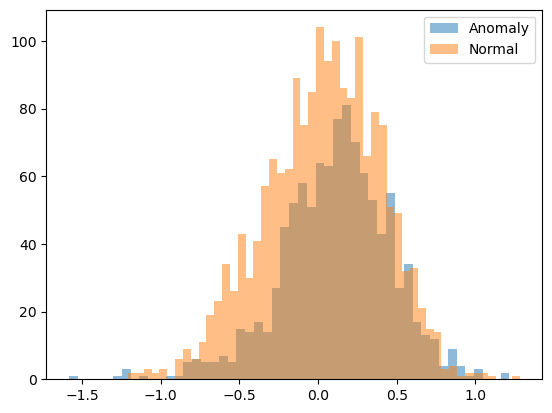

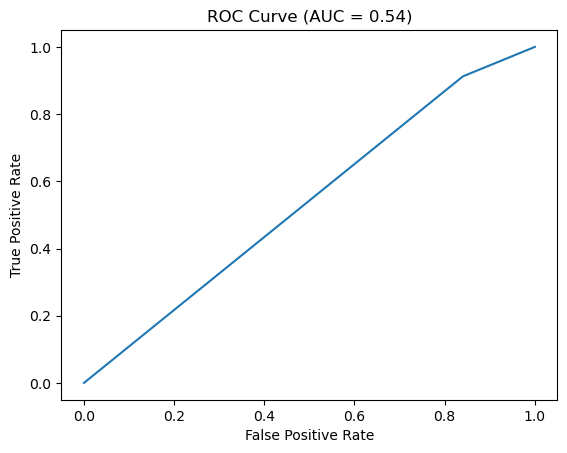

[I 2023-05-24 14:11:56,628] Trial 45 finished with value: 0.5425593514765489 and parameters: {'spectral_radius': 0.8989432031314629, 'sparsity': 0.06289955864836874, 'leaking_rate': 0.9345149509417515, 'input_scaling': 2.291414709697266, 'threshold': -0.33570748003932227, 'ridge_alpha': 0.05329833533214573}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.528885077526085
F1:  0.54148966298499
AUC:  0.528885077526085


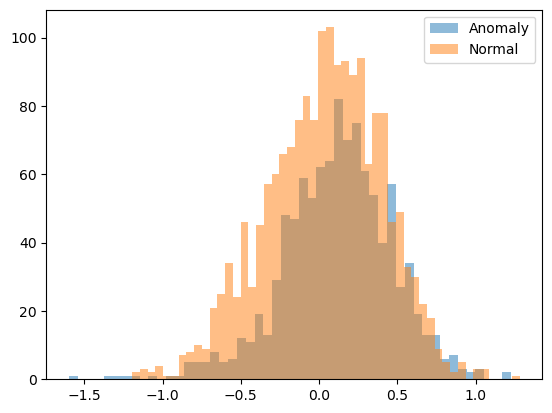

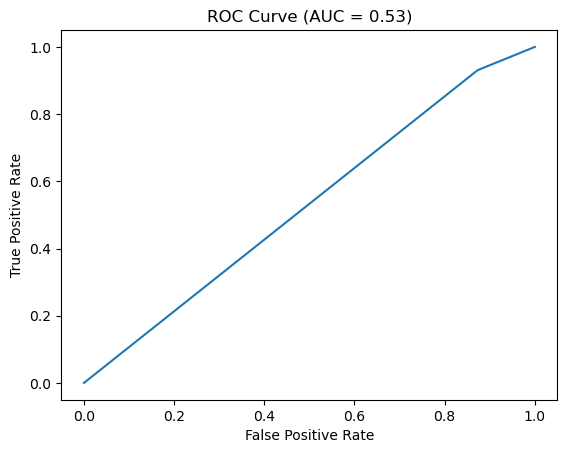

[I 2023-05-24 14:12:13,282] Trial 46 finished with value: 0.54148966298499 and parameters: {'spectral_radius': 0.6069786119472647, 'sparsity': 0.14178154331978424, 'leaking_rate': 0.9158485897444346, 'input_scaling': 1.0470824803944407, 'threshold': -0.39987857812764205, 'ridge_alpha': 0.20087408580895597}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5503717726296921
F1:  0.5356234096692113
AUC:  0.5503717726296921


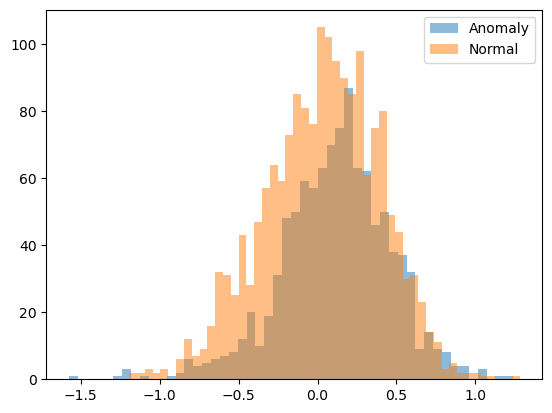

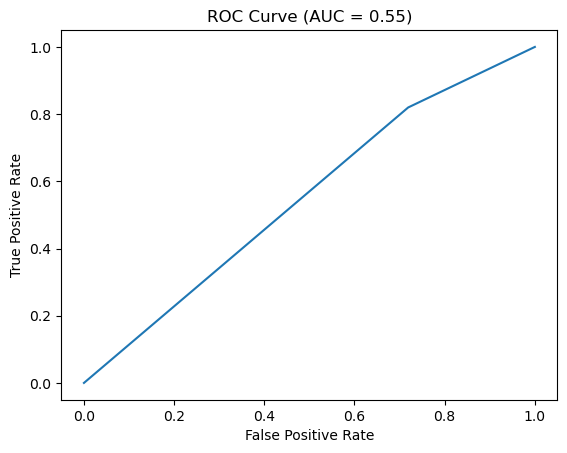

[I 2023-05-24 14:12:29,632] Trial 47 finished with value: 0.5356234096692113 and parameters: {'spectral_radius': 0.6765643626587436, 'sparsity': 0.08334241577595371, 'leaking_rate': 0.9772378026291696, 'input_scaling': 1.859296577726453, 'threshold': -0.1697642527669745, 'ridge_alpha': 0.03817857873955831}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5071355960965933
F1:  0.5354543003504988
AUC:  0.5071355960965933


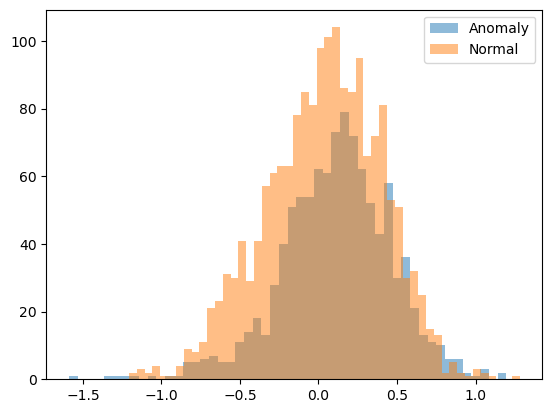

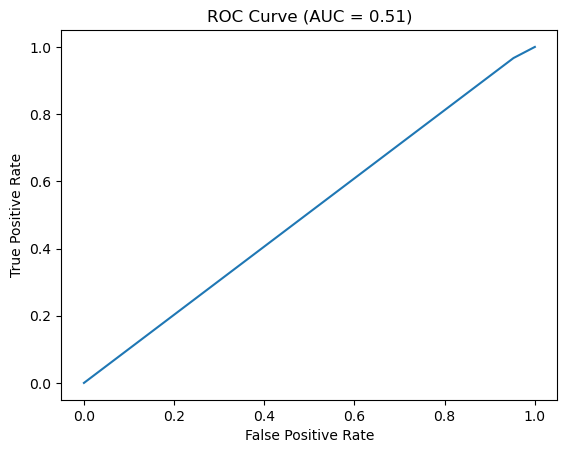

[I 2023-05-24 14:12:46,113] Trial 48 finished with value: 0.5354543003504988 and parameters: {'spectral_radius': 0.5070335431921271, 'sparsity': 0.040291173801528746, 'leaking_rate': 0.8909329193317613, 'input_scaling': 1.608527273260575, 'threshold': -0.6157512283482762, 'ridge_alpha': 0.11629572465000818}. Best is trial 21 with value: 0.5472096530920061.


Balanced acc:  0.5506905761034142
F1:  0.545289306270827
AUC:  0.5506905761034142


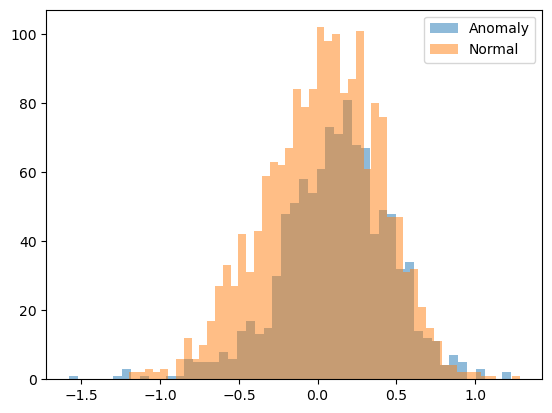

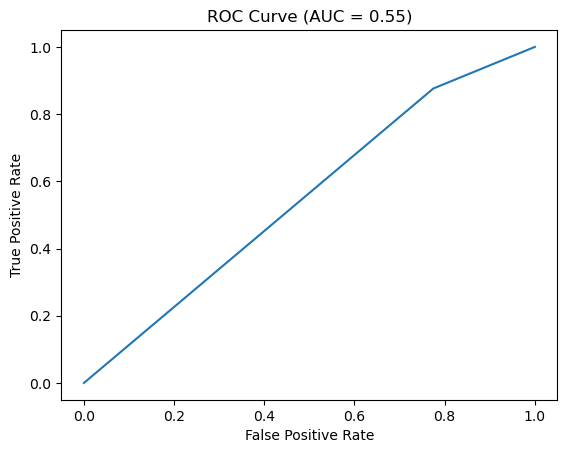

[I 2023-05-24 14:13:02,938] Trial 49 finished with value: 0.545289306270827 and parameters: {'spectral_radius': 0.44800023638038877, 'sparsity': 0.10127282628952718, 'leaking_rate': 0.9562900006982366, 'input_scaling': 2.0183474151700853, 'threshold': -0.2393099281273402, 'ridge_alpha': 0.4548094772374789}. Best is trial 21 with value: 0.5472096530920061.


Best hyperparameters: {'spectral_radius': 0.13269922318822394, 'sparsity': 0.07007870304659279, 'leaking_rate': 0.9469393320639427, 'input_scaling': 0.23576138591632556, 'threshold': -0.2610448567419277, 'ridge_alpha': 0.011186996262390614}
Best score: 0.5472096530920061


In [18]:
input_size = 200
reservoir_size = 800
output_size = 1


#np.random.seed(75)


#def prune(trial):





def objective(trial):
    # Define the search space for hyperparameters
    #reservoir_size = trial.suggest_int("reservoir_size", 500, 3000)
    spectral_radius = trial.suggest_float("spectral_radius", 0.0, 1.5)
    sparsity = trial.suggest_float("sparsity", 0.0, 0.2)
    leaking_rate = trial.suggest_float("leaking_rate", 0.7, 0.99)
    input_scaling = trial.suggest_float("input_scaling", 0.0, 5.0)
    threshold = trial.suggest_float("threshold", -1.0, 1.0)
    ridge_alpha = trial.suggest_float("ridge_alpha", 0.00001, 1.0)
    #random_seed = trial.suggest_int("random_seed", 1, 200)

    # Initialize the ESN with the given hyperparameters
    esn = ESN(input_size=input_size, reservoir_size=reservoir_size, output_size=output_size, 
              leaking_rate=leaking_rate, spectral_radius=spectral_radius, input_scaling=input_scaling, 
              threshold=threshold, sparsity=sparsity, ridge_alpha=ridge_alpha, random_seed=83)
    
    
    #esn = ESN(input_size=input_size, reservoir_size=reservoir_size, output_size=output_size, 
    #          leaking_rate=0.95, spectral_radius=spectral_radius, input_scaling=input_scaling, sparsity=0.1, 
    #          ridge_alpha=0.5, threshold=threshold, random_seed=83)
    
    #esn = ESN(input_size=input_size, reservoir_size=reservoir_size, output_size=output_size,
    #         leaking_rate=0.95, sparsity=0.1, random_seed=random_seed)

    # Train and evaluate the ESN on the training set
    #esn.fit(X_train_opt, y_train_opt)
    #esn.fit(X_train_new, y_train_new)
    esn.fit(esn_input_train, y_train)
    
    
    y_pred, y_prob = esn.predict(esn_input_val)
    score = f1_score(y_val.flatten(), y_pred.flatten())
    #score = roc_auc_score(y_val.flatten(), y_prob.flatten())
    fpr, tpr, thresholds = roc_curve(y_val.flatten(), y_pred.flatten())
    auc_score = auc(fpr, tpr)
    print("Balanced acc: ", balanced_accuracy_score(y_val.flatten(), y_pred.flatten()))
    print("F1: ", f1_score(y_val.flatten(), y_pred.flatten()))
    print("AUC: ", auc_score)
    
    y_prob = y_prob.flatten()
    anomaly_probs = y_prob[y_val.flatten().astype(bool)]
    non_anomaly_probs = y_prob[~y_val.flatten().astype(bool)]

    plt.hist(anomaly_probs, bins=50, alpha=0.5, label='Anomaly')
    plt.hist(non_anomaly_probs, bins=50, alpha=0.5, label='Normal')
    plt.legend(loc='upper right')
    plt.show()
    
    
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
    #trial_number = trial.number
    #if prune(trial):
    #    raise optuna.exceptions.TrialPruned()
    #print(trial.params, score)

    return score


study = optuna.create_study(direction="maximize")


study.optimize(objective, n_trials=50)#, n_jobs=-1)


best_params = study.best_params
best_score = study.best_value
print(f"Best hyperparameters: {best_params}")
print(f"Best score: {best_score}")
optuna.visualization.plot_param_importances(study)
plot_optimization_history(study)

In [ ]:
print(np.unique(y_test))

Actual anomalies:  436
Predicted anomalies 2109
Pred (14, 200, 1)
Pred flattened (2800,)
y_test (14, 200, 1)
y_test flattened (2800,)
Bal Acc:  0.6257761685217095
F1:  0.3308447937131631
AUC:  0.6257761685217095


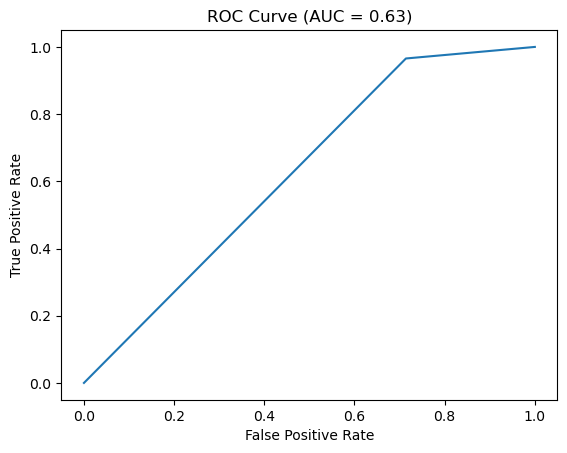

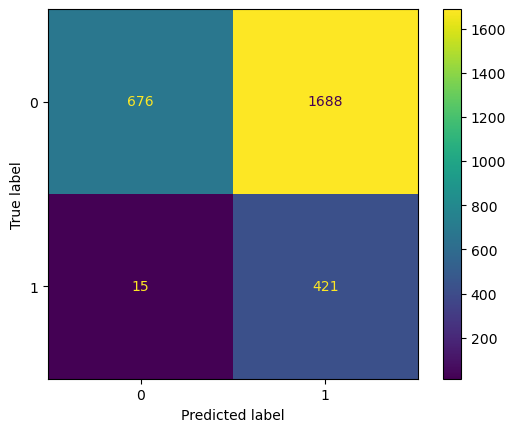

In [19]:




#esn = ESN(input_size=400, reservoir_size=500, output_size=1, alpha=0.5, gamma=0.1, spectral_radius=0.95, sparsity=0.1)
#esn = ESN(input_scaling=0.6075448519014384, input_size=400,
    #leaking_rate=0.17052412368729153, output_size=1, reservoir_size=1000,
    #sparsity=0.06505159298527952, spectral_radius=0.9488855372533332,
    #threshold=0.9656320330745594)
    
#np.random.seed(42)
#esn = ESN(input_scaling=0.6998812876189486, input_size=400,
#    leaking_rate=0.08210799041387684, output_size=1, reservoir_size=1000,
#    sparsity=0.9252733800015754, spectral_radius=0.3364410948180354, threshold=0.39462707778742845)

#0.9219100448194322


esn = ESN(input_size=200, reservoir_size=800, output_size=1, leaking_rate=0.9469393320639427, spectral_radius=0.13269922318822394, 
          sparsity=0.07007870304659279, input_scaling=0.23576138591632556, threshold=-0.2610448567419277, ridge_alpha=0.011186996262390614, random_seed=83)






#train_ESN(esn, pca_400, labels, epochs)


# ESN trained using dataset as shape (V*F, D)
#train_states = esn.fit(pca_400_train, labels_train)
#y_pred = esn.predict(pca_400_test)
#esn_accuracy = recall_score(labels_test, y_pred)
#print("ESN Accuracy: ", esn_accuracy)
#auc_score = roc_auc_score(labels_test, y_pred)
#print("ESN AUC: ", auc_score)




# Trained using (V, F, D)
#VF, D = pca_400_train.shape
#V = int(VF/200)
#F = 200
#train_data = pca_400_train.reshape(V, F, D)

#train_states = None



#esn.fit(esn_input_train, y_train)

esn.fit(esn_input_train, y_train)
    
#VF, D = pca_400_test.shape
#V = int(VF/200)
#F = 200
#test_data = pca_400_test.reshape(V, F, D)





#acc = np.zeros((V))
#for i in range(V):
#    y_pred = esn.predict(test_data[i])
#    esn_accuracy = recall_score(y_test[i], y_pred)
#    acc[i] = esn_accuracy
#    if 1 in y_test[i]:
#        auc_score = roc_auc_score(y_test[i], y_pred)
#        print(f"Accuracy for video {i}: {esn_accuracy}     AUC for video {i}: {auc_score}")
#    else:
#        print(f"Accuracy for video {i}: {esn_accuracy}")


#print(np.mean(acc))



#esn_pred, prob = esn.predict(esn_input_test)
esn_pred, outputs = esn.predict(esn_input_test)
fpr, tpr, thresholds = roc_curve(y_test.flatten(), esn_pred.flatten())
auc_score = auc(fpr, tpr)


print("Actual anomalies: ", np.count_nonzero(y_test.flatten()))
print("Predicted anomalies", np.count_nonzero(esn_pred.flatten()))
print("Pred", esn_pred.shape)
print("Pred flattened", esn_pred.flatten().shape)
print("y_test", y_test.shape)
print("y_test flattened", y_test.flatten().shape)
#print((prob >= 0.5).astype(int))

#print(esn_pred.flatten())
#print(y_test.flatten())
balanced_accuracy = balanced_accuracy_score(y_test.flatten(), esn_pred.flatten())
print("Bal Acc: ", balanced_accuracy)
print("F1: ", f1_score(y_test.flatten(), esn_pred.flatten()))
print("AUC: ", auc_score)



plt.plot(fpr, tpr)
plt.title(f'ROC Curve (AUC = {auc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()




cm = confusion_matrix(y_test.flatten(), esn_pred.flatten())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()






#esn_accuracy = accuracy_score(y_test, y_pred)
#print("ESN Accuracy: ", esn_accuracy)
#auc_score = roc_auc_score(y_test, y_pred)
#print("ESN AUC: ", auc_score)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

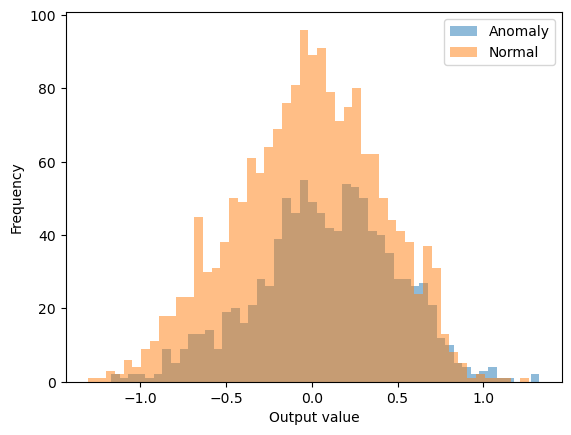

In [23]:



anomalies = y_test.astype(bool)
non_anomalies = ~anomalies





y_prob = outputs.flatten()
anomaly_probs = y_prob[y_val.flatten().astype(bool)]
non_anomaly_probs = y_prob[~y_val.flatten().astype(bool)]

plt.hist(anomaly_probs, bins=50, alpha=0.5, label='Anomaly')
plt.hist(non_anomaly_probs, bins=50, alpha=0.5, label='Normal')
plt.legend(loc='upper right')
plt.xlabel('Output value')
plt.ylabel('Frequency')
plt.show()



